In [16]:
import gc
import sys
from statistics import mean
import time
import torch
from tqdm import tqdm
from torchinfo import summary
import numpy as np
import itertools
from pathlib import Path
from scipy import special
import matplotlib.pyplot as plt
import datetime
import torch.linalg as LA
from torch.distributions.laplace import Laplace



import utils
import models
import learning_utils
from configurations import args_parser, arguments



In [17]:
%load_ext autoreload
%autoreload 2


start_time = time.time()
args = arguments()
#boardio is for the the tensorboardx prensetaion and textio is for written documentation
boardio, textio, best_val_acc, path_best_model, last_model_path = utils.initializations(args)
textio.cprint(str(args) if args.__class__.__name__ == 'Namespace' else str(vars(args)))

#mnist_train_data, mnist_test_loader  = utils.data(args)





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'exp_name': None, 'eval': False, 'data': 'mnist', 'norm_std': 0.5, 'norm_mean': 0.5, 'train_batch_size': 20, 'test_batch_size': 1000, 'model': 'cnn2', 'num_users': 30, 'num_users_per_round': 5, 'local_epochs': 1, 'local_iterations': 100, 'global_epochs': 200, 'tau_min': 0.05, 'privacy_noise': 'laplace', 'epsilon_bar': 400, 'optimizer': 'sgd', 'lr': 0.01, 'momentum': 0.5, 'lr_scheduler': False, 'device': device(type='cpu'), 'seed': 0, 'zeta_coeff': 1.05, 'alpha': 10, 'beta': 2, 'gamma': 0.2, 'max_seconds': 300, 'method_choosing_users': 'ALSA', 'data_truncation': 1750, 'choosing_users_verbose': True, 'save_best_model': False, 'privacy': True, 'privacy_choosing_users': True, 'epsilon_sum_deascent_coeff': 0.02, 'delta_f': 0.0008, 'snr_verbose': True, 'max_iterations_alsa': 500, 'ALSA_simulation': False, 'ALSA_verbose': False, 'beta_max_reduction': 20}


In [18]:
# data
train_data, test_loader = utils.data(args)
#input in the CNNs is the number of channels and in linear models is the size of the flatten pictures
input, output, train_data, val_loader = utils.data_split(train_data, len(test_loader.dataset), args)

# model
if args.model == 'mlp':
    global_model = models.FC2Layer(input, output)
elif args.model == 'cnn2':
    global_model = models.CNN2Layer(input, output, args.data)
elif args.model == 'cnn3':
    if args.data == 'cifar10':
        global_model = models.CNN3LayerCifar()
    else:
        global_model = models.CNN3LayerMnist()
elif args.model == 'cnn5':
    if args.data == 'mnist' or args.data == 'fashion mnist':
        raise ValueError('CNN5 is not supported for MNIST type datasets')
    global_model = models.CNN5Layer(input, output)
elif args.model == 'linear':
    global_model = models.Linear(input, output)



textio.cprint(str(summary(global_model)).encode('utf-8', errors='ignore').decode('utf-8', errors='ignore'))
global_model = global_model.to(args.device)
print(f"global model's device: {next(global_model.parameters()).device}")

train_criterion = torch.nn.CrossEntropyLoss(reduction='mean')
test_criterion = torch.nn.CrossEntropyLoss(reduction='sum')

local_models = utils.federated_setup(global_model, train_data, args, i_i_d=True)
utils.update_data_equility_partititon(local_models, args)





Layer (type:depth-idx)                   Param #
CNN2Layer                                --
├─Conv2d: 1-1                            156
├─Conv2d: 1-2                            906
├─Linear: 1-3                            4,850
├─Linear: 1-4                            510
├─Dropout: 1-5                           --
├─Dropout: 1-6                           --
├─BatchNorm2d: 1-7                       12
├─BatchNorm1d: 1-8                       100
Total params: 6,534
Trainable params: 6,534
Non-trainable params: 0
global model's device: cpu


In [19]:
# for i in range(100):
#     local_models[0].update_privacy_violation_and_reward()
#     print(f"iteration {i}, next_privacy_term is {local_models[0].next_privacy_term}")

  0%|          | 0/200 [00:00<?, ?it/s]

iteration: 1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
user 26, g: 0.027777777777777776, ucb: inf, num_of_obs: 1, privacy reward: 0.9801986733067553, curr_delay = 0.8555056544212304
user 22, g: 0.027777777777777776, ucb: inf, num_of_obs: 1, privacy reward: 0.9801986733067553, curr_delay = 0.791930648784264
user 3, g: 0.027777777777777776, ucb: inf, num_of_obs: 1, privacy reward: 0.9801986733067553, curr_delay = 0.09771709369846274
user 19, g: 0.027777777777777776, ucb: inf, num_of_obs: 1, privacy reward: 0.9801986733067553, curr_delay = 0.7581139407058375
user 28, g: 0.027777777777777776, ucb: inf, num_of_obs: 1, privacy reward: 0.9801986733067553, curr_delay = 0.9042388378013955
max_delay = 0.90 seconds
iteration: 2
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 23, 24, 25, 27, 29]
user 4, g: 0.027777777777777776, ucb: inf, num_of_obs: 1, privacy reward: 0.9801986733067553, curr_delay = 0.091

  4%|▎         | 7/200 [00:00<00:12, 15.39it/s]

user 0, g: 0.0005668934240362811, ucb: 8.586807371063939, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.05
user 1, g: 0.0005668934240362811, ucb: 8.4706316166292, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.06782083999430202
user 2, g: 0.0005668934240362811, ucb: 8.41238324207155, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.07693907563245218
user 3, g: 0.0005668934240362811, ucb: 8.152185405125662, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.09087059819865863
user 6, g: 0.0005668934240362811, ucb: 8.030557384999707, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.07528630082193308
max_delay = 0.09 seconds
iteration: 8
user 10, g: 0.0017361111111111104, ucb: 8.274008195213739, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.15427580972966032
user 4, g: 0.0017361111111111104, ucb: 8.44520958317835, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.1159

  4%|▍         | 9/200 [00:01<00:36,  5.20it/s]

user 12, g: 0.0030864197530864196, ucb: 8.368465319571012, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.1866433502255553
user 13, g: 0.0030864197530864196, ucb: 8.376317196025441, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.2018586881663652
user 14, g: 0.0030864197530864196, ucb: 8.393689702486745, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.19198013210572618
user 15, g: 0.0030864197530864196, ucb: 8.188125629944413, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.6945868576986042
user 9, g: 0.0030864197530864196, ucb: 8.385287090049165, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.14437330019351868
max_delay = 0.69 seconds
iteration: 10


  5%|▌         | 10/200 [00:02<00:50,  3.80it/s]

user 16, g: 0.004444444444444443, ucb: 8.376173631299787, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.7219343876357545
user 19, g: 0.004444444444444443, ucb: 8.377243828115873, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.7998079591991623
user 20, g: 0.004444444444444443, ucb: 8.375228874541284, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.7910710781072136
user 21, g: 0.004444444444444443, ucb: 8.376529338381394, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.7913354195249774
user 22, g: 0.004444444444444443, ucb: 8.374427523033338, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.7878528343418966
max_delay = 0.80 seconds
iteration: 11


  6%|▌         | 11/200 [00:02<01:04,  2.92it/s]

user 11, g: 0.005739210284664828, ucb: 8.799420329059856, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.162288589900495
user 18, g: 0.005739210284664828, ucb: 8.546759185243847, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.7413142621543798
user 23, g: 0.005739210284664828, ucb: 8.542353384688496, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.8119496557169447
user 24, g: 0.005739210284664828, ucb: 8.541227433653518, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.8151183703750421
user 25, g: 0.005739210284664828, ucb: 8.540571286704232, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.8291273371242378
max_delay = 0.83 seconds
iteration: 12


  6%|▌         | 12/200 [00:03<01:09,  2.71it/s]

user 0, g: 0.0, ucb: 7.078362452509687, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.06029733149612926
user 17, g: 0.006944444444444444, ucb: 8.700371848899493, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.7538748445832795
user 26, g: 0.006944444444444444, ucb: 8.692516978447935, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.862024395768712
user 28, g: 0.006944444444444444, ucb: 8.689367136625016, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.9011467641907752
user 29, g: 0.006944444444444444, ucb: 8.68990516310815, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.9086101443120211
max_delay = 0.91 seconds
iteration: 13


  6%|▋         | 13/200 [00:03<01:17,  2.41it/s]

user 1, g: 0.00016436554898093314, ucb: 6.9864426713833305, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.06815803562537794
user 2, g: 0.00016436554898093314, ucb: 6.9136326440618046, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.05724114398177678
user 27, g: 0.008053911900065745, ucb: 8.829572092156635, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.8761269090647558
user 3, g: 0.00016436554898093314, ucb: 6.733717795853497, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.07404228760934425
user 6, g: 0.00016436554898093314, ucb: 6.7298530201539695, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.12207008100075589
max_delay = 0.88 seconds
iteration: 14


  7%|▋         | 14/200 [00:04<01:22,  2.26it/s]

user 10, g: 0.0005668934240362811, ucb: 6.641627753399947, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.14933425297709746
user 11, g: 0.0005668934240362811, ucb: 6.604706272730706, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.16652920266621812
user 4, g: 0.0005668934240362811, ucb: 6.7807710203317555, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.11123445521901501
user 5, g: 0.0005668934240362811, ucb: 6.746899589815719, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.11889856904183249
user 8, g: 0.0005668934240362811, ucb: 6.672493540348825, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.15040851419484882
max_delay = 0.17 seconds
iteration: 15


  8%|▊         | 15/200 [00:04<01:24,  2.18it/s]

user 12, g: 0.0011111111111111107, ucb: 6.632163022890611, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.2045125602240761
user 13, g: 0.0011111111111111107, ucb: 6.62599267514084, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.1911876690528407
user 14, g: 0.0011111111111111107, ucb: 6.641051720384201, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.19228374212712457
user 15, g: 0.0011111111111111107, ucb: 6.444040494417787, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.7540479468941894
user 7, g: 0.0011111111111111107, ucb: 6.706771998410413, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.1349369263072016
max_delay = 0.75 seconds
iteration: 16


  8%|▊         | 16/200 [00:05<01:31,  2.01it/s]

user 17, g: 0.0017361111111111104, ucb: 6.515252209709848, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.7430289904836564
user 18, g: 0.0017361111111111104, ucb: 6.515263823932568, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.7619448023797152
user 19, g: 0.0017361111111111104, ucb: 6.513174364424051, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.7797481698997376
user 21, g: 0.0017361111111111104, ucb: 6.513151782243576, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.8045962307255222
user 9, g: 0.0017361111111111104, ucb: 6.755289882707974, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.136151712357106
max_delay = 0.80 seconds
iteration: 17


  8%|▊         | 17/200 [00:06<01:43,  1.78it/s]

user 16, g: 0.002402921953094963, ucb: 6.5861350230942515, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.7026421353372927
user 20, g: 0.002402921953094963, ucb: 6.582636181781521, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.784715151470289
user 23, g: 0.002402921953094963, ucb: 6.580251195579205, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.8193350507673521
user 24, g: 0.002402921953094963, ucb: 6.579568525792217, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.8575043466986543
user 25, g: 0.002402921953094963, ucb: 6.578722244216832, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.8228093802727733
max_delay = 0.86 seconds
iteration: 18


  9%|▉         | 18/200 [00:06<01:48,  1.68it/s]

user 22, g: 0.0030864197530864196, ucb: 6.647795384447245, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.8284160542287793
user 26, g: 0.0030864197530864196, ucb: 6.64271913214926, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.8541269442246929
user 27, g: 0.0030864197530864196, ucb: 6.6418017175493445, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.8835870806698956
user 28, g: 0.0030864197530864196, ucb: 6.639885140696179, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.917542631509207
user 29, g: 0.0030864197530864196, ucb: 6.639926275905147, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.9105243626409847
max_delay = 0.92 seconds
iteration: 19


 10%|▉         | 19/200 [00:07<01:38,  1.83it/s]

user 0, g: 7.694675284702985e-05, ucb: 6.351444249762842, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.05
user 1, g: 7.694675284702985e-05, ucb: 6.193252879495534, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.08008756235138492
user 2, g: 7.694675284702985e-05, ucb: 6.191348977880498, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.08939386957946843
user 3, g: 7.694675284702985e-05, ucb: 6.005336482913437, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.08470297368179415
user 6, g: 7.694675284702985e-05, ucb: 5.914196965205493, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.11904038039173653
max_delay = 0.12 seconds
iteration: 20


 10%|█         | 20/200 [00:07<01:34,  1.91it/s]

user 10, g: 0.00027777777777777767, ucb: 5.818200271241191, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.15634073627555878
user 4, g: 0.00027777777777777767, ucb: 5.949189663744487, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.12337730911775861
user 5, g: 0.00027777777777777767, ucb: 5.916950542509981, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.08464031766402766
user 7, g: 0.00027777777777777767, ucb: 5.819063320037872, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.16407566934715864
user 8, g: 0.00027777777777777767, ucb: 5.837980336875799, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.13286946105470188
max_delay = 0.16 seconds
iteration: 21


 10%|█         | 21/200 [00:08<01:33,  1.91it/s]

user 11, g: 0.0005668934240362811, ucb: 5.826452864775866, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.1624913123519873
user 12, g: 0.0005668934240362811, ucb: 5.771694915595193, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.17929586681385745
user 14, g: 0.0005668934240362811, ucb: 5.782803588312753, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.20115360086132256
user 16, g: 0.0005668934240362811, ucb: 5.58615289515949, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.6958564454157756
user 9, g: 0.0005668934240362811, ucb: 5.844364656115266, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.1071142251407585
max_delay = 0.70 seconds
iteration: 22


 11%|█         | 22/200 [00:08<01:36,  1.85it/s]

user 15, g: 0.0009182736455463729, ucb: 5.628883537347922, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.7112533456800443
user 17, g: 0.0009182736455463729, ucb: 5.626353085648681, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.7177016109823693
user 18, g: 0.0009182736455463729, ucb: 5.625803970459552, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.788468596050267
user 19, g: 0.0009182736455463729, ucb: 5.6239115692873645, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.7838112345749616
user 21, g: 0.0009182736455463729, ucb: 5.623236415776321, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.8047656991162583
max_delay = 0.80 seconds
iteration: 23


 12%|█▏        | 23/200 [00:09<01:39,  1.77it/s]

user 13, g: 0.0013127494223902538, ucb: 5.8550904047722305, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.19961523962878233
user 20, g: 0.0013127494223902538, ucb: 5.663168731232995, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.7992743690673048
user 22, g: 0.0013127494223902538, ucb: 5.661867260977172, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.8315334466050351
user 23, g: 0.0013127494223902538, ucb: 5.66068130961693, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.8209894202982136
user 25, g: 0.0013127494223902538, ucb: 5.659576115468546, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.8486235786213658
max_delay = 0.85 seconds
iteration: 24


 12%|█▏        | 24/200 [00:10<01:41,  1.73it/s]

user 24, g: 0.0017361111111111104, ucb: 5.697195376124558, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.8092822612354619
user 26, g: 0.0017361111111111104, ucb: 5.695752111007735, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.8749082550760635
user 27, g: 0.0017361111111111104, ucb: 5.694489904772284, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.8676578770715401
user 28, g: 0.0017361111111111104, ucb: 5.6925141410665265, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.8912714246454914
user 29, g: 0.0017361111111111104, ucb: 5.6926815751431485, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.9194418071091425
max_delay = 0.92 seconds
iteration: 25


 12%|█▎        | 25/200 [00:10<01:34,  1.86it/s]

user 0, g: 4.444444444444428e-05, ucb: 5.857288849737702, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.0504851889820934
user 1, g: 4.444444444444428e-05, ucb: 5.644724488801669, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.08374782937153567
user 2, g: 4.444444444444428e-05, ucb: 5.6270480135047976, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.08893773532583105
user 3, g: 4.444444444444428e-05, ucb: 5.495282536529344, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.08716538300213326
user 6, g: 4.444444444444428e-05, ucb: 5.384359771202409, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.11349742744831469
max_delay = 0.11 seconds
iteration: 26


 13%|█▎        | 26/200 [00:10<01:25,  2.03it/s]

user 0, g: -0.0006574621959237354, ucb: 5.374560874031543, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.07365265151123215
user 4, g: 0.00016436554898093314, ucb: 5.401461596579477, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.06932698347766769
user 5, g: 0.00016436554898093314, ucb: 5.4236507850454565, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.11044822182499096
user 8, g: 0.00016436554898093314, ucb: 5.310816673958189, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.15051178796729148
user 9, g: 0.00016436554898093314, ucb: 5.304932349290563, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.18149388465024502
max_delay = 0.18 seconds
iteration: 27


 14%|█▎        | 27/200 [00:11<01:25,  2.03it/s]

user 10, g: 0.0003429355281207133, ucb: 5.310405659457062, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.17194140289179183
user 11, g: 0.0003429355281207133, ucb: 5.280275606973653, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.18387043220611834
user 12, g: 0.0003429355281207133, ucb: 5.231997123067785, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.1878415643386347
user 14, g: 0.0003429355281207133, ucb: 5.232753027160192, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.17542904513202934
user 7, g: 0.0003429355281207133, ucb: 5.307283736913667, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.1334759882505937
max_delay = 0.19 seconds
iteration: 28


 14%|█▍        | 28/200 [00:11<01:27,  1.97it/s]

user 13, g: 0.0005668934240362811, ucb: 5.253430292245396, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.17235591279467646
user 15, g: 0.0005668934240362811, ucb: 5.068604751872307, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.7276669141161228
user 16, g: 0.0005668934240362811, ucb: 5.068442111394742, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.7130364320105398
user 17, g: 0.0005668934240362811, ucb: 5.066549012175451, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.7298242908159287
user 18, g: 0.0005668934240362811, ucb: 5.064573983563485, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.7317253241735131
max_delay = 0.73 seconds
iteration: 29


 14%|█▍        | 29/200 [00:12<01:31,  1.86it/s]

user 19, g: 0.0008257365570088515, ucb: 5.089502891731675, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.7599683211361116
user 20, g: 0.0008257365570088515, ucb: 5.088761761420842, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.7672556220796098
user 21, g: 0.0008257365570088515, ucb: 5.088581280424965, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.8016329027943745
user 22, g: 0.0008257365570088515, ucb: 5.087178941470929, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.8199028877179283
user 23, g: 0.0008257365570088515, ucb: 5.08648254102203, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.8208311306290523
max_delay = 0.82 seconds
iteration: 30


 15%|█▌        | 30/200 [00:13<01:31,  1.86it/s]

user 24, g: 0.0011111111111111107, ucb: 5.11091663181382, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.8282611769641687
user 25, g: 0.0011111111111111107, ucb: 5.110392108736393, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.8463982176501127
user 26, g: 0.0011111111111111107, ucb: 5.108675610062198, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.8852526190605909
user 27, g: 0.0011111111111111107, ucb: 5.107848343098995, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.8620366852254155
user 28, g: 0.0011111111111111107, ucb: 5.105984828586004, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.9033986379454093
max_delay = 0.90 seconds
iteration: 31


 16%|█▌        | 31/200 [00:13<01:25,  1.98it/s]

user 1, g: 2.8905075731298364e-05, ucb: 5.243614504961567, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.07363237771068834
user 2, g: 2.8905075731298364e-05, ucb: 5.22250545757018, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.09316753445685111
user 29, g: 0.001416348710833622, ucb: 5.129968090047296, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.872871327616598
user 3, g: 2.8905075731298364e-05, ucb: 5.11937930614972, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.09035198636369675
user 4, g: 2.8905075731298364e-05, ucb: 5.049967437669959, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.0983512501882487
max_delay = 0.87 seconds
iteration: 32


 16%|█▌        | 32/200 [00:13<01:21,  2.05it/s]

user 5, g: 0.00010850694444444425, ucb: 5.034949918830006, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.11086189065855136
user 6, g: 0.00010850694444444425, ucb: 5.024959322126693, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.12588832443471049
user 7, g: 0.00010850694444444425, ucb: 4.903397748865098, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.1108896534539064
user 8, g: 0.00010850694444444425, ucb: 4.920582445813155, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.14403849494107354
user 9, g: 0.00010850694444444425, ucb: 4.904533282470624, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.15514140067277954
max_delay = 0.16 seconds
iteration: 33


 16%|█▋        | 33/200 [00:14<01:21,  2.05it/s]

user 0, g: -0.00022956841138659364, ucb: 5.0886756347999755, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.05
user 1, g: -0.00022956841138659364, ucb: 4.881437367022357, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.06418601805421048
user 10, g: 0.0002295684113865928, ucb: 4.909334170945625, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.14542378642740816
user 11, g: 0.0002295684113865928, ucb: 4.881456903613464, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.14069125696186652
user 14, g: 0.0002295684113865928, ucb: 4.846055819852953, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.18303166254943612
max_delay = 0.18 seconds
iteration: 34


 17%|█▋        | 34/200 [00:14<01:20,  2.07it/s]

user 12, g: 0.0003844675124951936, ucb: 4.861195898285346, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.16960346468353582
user 13, g: 0.0003844675124951936, ucb: 4.861241400324178, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.19929704503524936
user 15, g: 0.0003844675124951936, ucb: 4.669104041993298, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.7069188355549181
user 16, g: 0.0003844675124951936, ucb: 4.669255907002489, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.7119778101011731
user 3, g: -9.611687812379895e-05, ucb: 4.774776589573738, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.09071085206310898
max_delay = 0.71 seconds
iteration: 35


 18%|█▊        | 35/200 [00:15<01:19,  2.07it/s]

user 17, g: 0.0005668934240362811, ucb: 4.686285869344238, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.7530351414779571
user 18, g: 0.0005668934240362811, ucb: 4.684670248639982, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.7336037312623793
user 20, g: 0.0005668934240362811, ucb: 4.68238439981312, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.7820966861148417
user 22, g: 0.0005668934240362811, ucb: 4.68028124432204, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.8016188071089111
user 23, g: 0.0005668934240362811, ucb: 4.679710331386269, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.8135230733695547
max_delay = 0.81 seconds
iteration: 36


 18%|█▊        | 36/200 [00:15<01:22,  1.99it/s]

user 19, g: 0.000771604938271604, ucb: 4.70136423324341, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.7674113312873829
user 21, g: 0.000771604938271604, ucb: 4.69994303884688, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.794895770655998
user 24, g: 0.000771604938271604, ucb: 4.697222860434269, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.8371368406989349
user 25, g: 0.000771604938271604, ucb: 4.696544525320672, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.8526360872771777
user 26, g: 0.000771604938271604, ucb: 4.694652767278663, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.8678475422668274
max_delay = 0.87 seconds
iteration: 37


 18%|█▊        | 37/200 [00:16<01:17,  2.10it/s]

user 2, g: 2.029056083110121e-05, ucb: 4.90797302687389, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.06715649424957804
user 27, g: 0.000994237480723966, ucb: 4.711988007950642, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.8945896365617524
user 28, g: 0.000994237480723966, ucb: 4.709966072428614, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.898111286762838
user 29, g: 0.000994237480723966, ucb: 4.71010990219483, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.8903229250693829
user 5, g: 2.029056083110121e-05, ucb: 4.719954952082272, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.12509371830880006
max_delay = 0.90 seconds
iteration: 38


 19%|█▉        | 38/200 [00:16<01:12,  2.24it/s]

user 0, g: -0.0003077870113881194, ucb: 4.869056415742202, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.05
user 1, g: -0.0003077870113881194, ucb: 4.659850165163705, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.07201455644870072
user 4, g: 7.694675284702985e-05, ucb: 4.775138839131182, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.07111973309123809
user 6, g: 7.694675284702985e-05, ucb: 4.7183188659134645, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.12488618357272026
user 7, g: 7.694675284702985e-05, ucb: 4.625971100525331, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.15891250018231995
max_delay = 0.16 seconds
iteration: 39


 20%|█▉        | 39/200 [00:17<01:08,  2.34it/s]

user 0, g: -0.0014792899408284025, ucb: 4.637126223406293, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.05
user 10, g: 0.00016436554898093314, ucb: 4.611439139050775, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.18320475473713826
user 2, g: -0.00016436554898093385, ucb: 4.633582057519506, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.08113466624166787
user 8, g: 0.00016436554898093314, ucb: 4.638196635886983, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.1371701413171426
user 9, g: 0.00016436554898093314, ucb: 4.620681868046857, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.14288176251996199
max_delay = 0.18 seconds
iteration: 40


 20%|██        | 40/200 [00:17<01:08,  2.33it/s]

user 11, g: 0.00027777777777777767, ucb: 4.604898866077689, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.14827721978988073
user 12, g: 0.00027777777777777767, ucb: 4.561657933583213, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.1917198774565897
user 13, g: 0.00027777777777777767, ucb: 4.55437526773264, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.20174462700011697
user 14, g: 0.00027777777777777767, ucb: 4.561696074304066, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.2173143122333628
user 3, g: -6.944444444444442e-05, ucb: 4.548359455295259, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.08963855699472369
max_delay = 0.22 seconds
iteration: 41


 20%|██        | 41/200 [00:18<01:15,  2.11it/s]

user 15, g: 0.0004131138872364333, ucb: 4.378585349297815, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.7055408641948565
user 17, g: 0.0004131138872364333, ucb: 4.376459084435014, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.7257432865295993
user 20, g: 0.0004131138872364333, ucb: 4.372796651633599, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.762497715963762
user 21, g: 0.0004131138872364333, ucb: 4.372038993251005, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.8181042497627482
user 22, g: 0.0004131138872364333, ucb: 4.37078453397894, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.8115558746246898
max_delay = 0.82 seconds
iteration: 42


 21%|██        | 42/200 [00:18<01:15,  2.09it/s]

user 1, g: -0.0005668934240362811, ucb: 4.453159638667887, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.06852874631473298
user 2, g: -0.0005668934240362811, ucb: 4.408106187113513, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.10370252300241024
user 4, g: 0.0, ucb: 4.540248990667847, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.10764372867324111
user 5, g: 0.0, ucb: 4.463038691039712, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.06479333295678605
user 6, g: 0.0, ucb: 4.448306840148917, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.1493385765852232
max_delay = 0.15 seconds
iteration: 43


 22%|██▏       | 43/200 [00:19<01:24,  1.85it/s]

user 16, g: 0.000736133645814554, ucb: 4.406172713265002, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.7277734520989132
user 18, g: 0.000736133645814554, ucb: 4.402950425865083, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.765118569412324
user 23, g: 0.000736133645814554, ucb: 4.39770122559139, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.8289894645898551
user 24, g: 0.000736133645814554, ucb: 4.396787759886197, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.800971307636605
user 25, g: 0.000736133645814554, ucb: 4.396041526212737, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.856129631188667
max_delay = 0.86 seconds
iteration: 44


 22%|██▏       | 44/200 [00:20<01:34,  1.65it/s]

user 19, g: 0.0009182736455463729, ucb: 4.4143763938331535, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.7541821777389541
user 26, g: 0.0009182736455463729, ucb: 4.407526788706021, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.8712442747195325
user 27, g: 0.0009182736455463729, ucb: 4.4069417542920615, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.8624594749359172
user 28, g: 0.0009182736455463729, ucb: 4.405220281280363, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.9008265536446602
user 29, g: 0.0009182736455463729, ucb: 4.405421307850702, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.908000542816755
max_delay = 0.91 seconds
iteration: 45


 22%|██▎       | 45/200 [00:20<01:25,  1.81it/s]

user 0, g: -0.0011111111111111124, ucb: 4.5004534838540025, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.06216010484801642
user 10, g: 0.00012345679012345652, ucb: 4.362230779238781, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.15046046495115406
user 7, g: 0.00012345679012345652, ucb: 4.393675156833953, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.121066625681401
user 8, g: 0.00012345679012345652, ucb: 4.398250367105307, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.1433929452578318
user 9, g: 0.00012345679012345652, ucb: 4.381156119993362, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.15405693973577902
max_delay = 0.15 seconds
iteration: 46


 23%|██▎       | 46/200 [00:20<01:22,  1.86it/s]

user 11, g: 0.0002100399075824401, ucb: 4.3647982517609325, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.1653284441424346
user 12, g: 0.0002100399075824401, ucb: 4.316819016436072, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.1724919197709999
user 14, g: 0.0002100399075824401, ucb: 4.312463754797085, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.21928584632785075
user 3, g: -5.250997689561023e-05, ucb: 4.359555824772695, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.0831089446256395
user 4, g: -5.250997689561023e-05, ucb: 4.31786441155917, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.09647511400007679
max_delay = 0.22 seconds
iteration: 47


 24%|██▎       | 47/200 [00:21<01:15,  2.04it/s]

user 0, g: -0.002125144610432072, ucb: 4.3235095768767895, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.10415283812592058
user 1, g: -0.0006161661888235003, ucb: 4.2940173316162005, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.0669879268338302
user 13, g: 0.0003143705045017855, ucb: 4.320086378149098, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.17647431894060175
user 5, g: -1.2574820180071461e-05, ucb: 4.2993312265349415, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.10973515147017301
user 6, g: -1.2574820180071461e-05, ucb: 4.231831524368011, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.10111506572760655
max_delay = 0.18 seconds
iteration: 48


 24%|██▍       | 48/200 [00:21<01:18,  1.94it/s]

user 15, g: 0.000434027777777777, ucb: 4.142918924050684, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.7017891060101572
user 16, g: 0.000434027777777777, ucb: 4.1426463292204465, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.7105406920568724
user 17, g: 0.000434027777777777, ucb: 4.140814592349519, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.7617654032861542
user 18, g: 0.000434027777777777, ucb: 4.139405318596122, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.7406897758543308
user 19, g: 0.000434027777777777, ucb: 4.137991777741867, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.7804050511784292
max_delay = 0.78 seconds
iteration: 49


 24%|██▍       | 49/200 [00:22<01:18,  1.92it/s]

user 20, g: 0.0005668934240362811, ucb: 4.148034109755882, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.807311525646893
user 21, g: 0.0005668934240362811, ucb: 4.146747965204398, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8136255357813199
user 22, g: 0.0005668934240362811, ucb: 4.1457431639850375, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8576563981858865
user 23, g: 0.0005668934240362811, ucb: 4.145019887691573, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.7981260325077343
user 25, g: 0.0005668934240362811, ucb: 4.143324141539379, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8350734343512642
max_delay = 0.86 seconds
iteration: 50


 25%|██▌       | 50/200 [00:22<01:15,  1.97it/s]

user 24, g: 0.00071111111111111, ucb: 4.155124815604387, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8337477998329016
user 26, g: 0.00071111111111111, ucb: 4.15226780507255, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8800934377505196
user 27, g: 0.00071111111111111, ucb: 4.151849854448652, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8780939323585113
user 28, g: 0.00071111111111111, ucb: 4.150021569312649, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8812726283916898
user 29, g: 0.00071111111111111, ucb: 4.150131230063663, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.9056690469869205
max_delay = 0.91 seconds
iteration: 51


 26%|██▌       | 51/200 [00:23<01:13,  2.02it/s]

user 2, g: -9.611687812379895e-05, ucb: 4.264272786282121, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.07738341005961041
user 3, g: -9.611687812379895e-05, ucb: 4.194136465703538, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.08960214560935129
user 7, g: 9.61168781237984e-05, ucb: 4.201721067240677, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.1393400697247662
user 8, g: 9.61168781237984e-05, ucb: 4.19768643306416, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.15103561253422587
user 9, g: 9.61168781237984e-05, ucb: 4.179711858697074, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.16434077903680663
max_delay = 0.16 seconds
iteration: 52


 26%|██▌       | 52/200 [00:23<01:10,  2.10it/s]

user 0, g: -0.002013477975016437, ucb: 4.16717427338693, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.08506369600826331
user 1, g: -0.0006574621959237354, ucb: 4.157991118836777, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.08052645837583196
user 10, g: 0.00016436554898093314, ucb: 4.1735921333722725, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.18274403800462513
user 11, g: 0.00016436554898093314, ucb: 4.1619148444783525, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.18230065432250642
user 4, g: -4.109138724523346e-05, ucb: 4.1567447454440405, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.1132997449596691
max_delay = 0.18 seconds
iteration: 53


 26%|██▋       | 53/200 [00:24<01:08,  2.15it/s]

user 12, g: 0.0002472212333372888, ucb: 4.127630290718943, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.18706305655546793
user 13, g: 0.0002472212333372888, ucb: 4.119730742060987, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.21176577902619276
user 14, g: 0.0002472212333372888, ucb: 4.1160874669791525, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.19194615595558634
user 5, g: -9.88884933349155e-06, ucb: 4.132603213841752, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.09176201853957161
user 6, g: -9.88884933349155e-06, ucb: 4.076919438916482, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.1276351275217767
max_delay = 0.21 seconds
iteration: 54


 27%|██▋       | 54/200 [00:24<01:05,  2.21it/s]

user 1, g: -0.0013717421124828531, ucb: 4.004847111696735, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.05
user 2, g: -0.0003429355281207133, ucb: 4.103577609196786, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.07991330075008449
user 3, g: -0.0003429355281207133, ucb: 4.031643823388398, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.08344443476666694
user 7, g: 0.0, ucb: 4.007997624270111, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.135892364272437
user 8, g: 0.0, ucb: 4.001323885671306, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.11922513071390806
max_delay = 0.14 seconds
iteration: 55


 28%|██▊       | 55/200 [00:25<01:10,  2.04it/s]

user 15, g: 0.0004499540863177226, ucb: 3.9464521449791494, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7142197629927104
user 16, g: 0.0004499540863177226, ucb: 3.946103933449192, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7101355568309689
user 18, g: 0.0004499540863177226, ucb: 3.94291001139266, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7589820312919232
user 19, g: 0.0004499540863177226, ucb: 3.941243744227133, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7414745740608157
user 20, g: 0.0004499540863177226, ucb: 3.9402848510898147, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7583542651092358
max_delay = 0.76 seconds
iteration: 56


 28%|██▊       | 56/200 [00:25<01:13,  1.95it/s]

user 10, g: 3.5430839002267324e-05, ucb: 3.9816911014028027, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.15763341565713318
user 17, g: 0.0005668934240362811, ucb: 3.952615082682598, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7437083785465395
user 21, g: 0.0005668934240362811, ucb: 3.9478048076641556, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7831036113165287
user 22, g: 0.0005668934240362811, ucb: 3.946531240741335, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.786044224565419
user 23, g: 0.0005668934240362811, ucb: 3.946441916799711, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7971752695488913
max_delay = 0.80 seconds
iteration: 57


 28%|██▊       | 57/200 [00:26<01:11,  1.99it/s]

user 24, g: 0.0006925207756232686, ucb: 3.9542183483750986, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.84301614753407
user 25, g: 0.0006925207756232686, ucb: 3.9531440434369247, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.8209932364488657
user 26, g: 0.0006925207756232686, ucb: 3.9513237111971677, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.8408907391262357
user 27, g: 0.0006925207756232686, ucb: 3.950974175250861, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.8872977061716197
user 28, g: 0.0006925207756232686, ucb: 3.949348752689539, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.8948953594509041
max_delay = 0.89 seconds
iteration: 58


 29%|██▉       | 58/200 [00:26<01:07,  2.10it/s]

user 0, g: -0.0016184436517373503, ucb: 4.045831269943669, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.05
user 11, g: 0.00013211784912141598, ucb: 3.987316988031605, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.1505497990461655
user 4, g: -3.3029462280354315e-05, ucb: 4.009131820408439, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.11890192347999615
user 5, g: -3.3029462280354315e-05, ucb: 3.98989898311952, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.10832317524726437
user 9, g: 0.00013211784912141598, ucb: 4.014884929072928, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.148066719706129
max_delay = 0.15 seconds
iteration: 59


 30%|██▉       | 59/200 [00:27<01:05,  2.15it/s]

user 12, g: 0.0001994956749337669, ucb: 3.955564520292768, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.18918254578750154
user 13, g: 0.0001994956749337669, ucb: 3.9450782954533223, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.2232359158972722
user 14, g: 0.0001994956749337669, ucb: 3.9445486957380522, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.19045677743616915
user 2, g: -0.0003910115228701847, ucb: 3.9773108998151736, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.08061760077793163
user 29, g: 0.0009655590666794338, ucb: 3.965824824524763, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.9396736302951999
max_delay = 0.94 seconds
iteration: 60


 30%|███       | 60/200 [00:27<01:01,  2.28it/s]

user 1, g: -0.0011111111111111124, ucb: 3.93031804214924, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.05
user 3, g: -0.00027777777777777767, ucb: 3.916375205828125, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.09069094969135662
user 6, g: 0.0, ucb: 3.9390088254253888, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.14952311458587775
user 7, g: 0.0, ucb: 3.866900648305782, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.09424581160573119
user 8, g: 0.0, ucb: 3.866037924736083, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.15088224750372342
max_delay = 0.15 seconds
iteration: 61


 30%|███       | 61/200 [00:27<01:01,  2.26it/s]

user 10, g: 7.465137806443923e-06, ucb: 3.830291238305066, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.16253587810199316
user 15, g: 0.0003657917525157512, ucb: 3.771674411995834, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.71725304697155
user 16, g: 0.0003657917525157512, ucb: 3.7714096271385107, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.7170239049839126
user 17, g: 0.0003657917525157512, ucb: 3.7691060117626813, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.7192121855033864
user 18, g: 0.0003657917525157512, ucb: 3.768067098653448, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.7374015980433798
max_delay = 0.74 seconds
iteration: 62


 31%|███       | 62/200 [00:28<01:01,  2.26it/s]

user 11, g: 2.8905075731298364e-05, ucb: 3.8294469489734757, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.1856065513040492
user 12, g: 2.8905075731298364e-05, ucb: 3.787125152750797, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.1946486638985833
user 2, g: -0.0007226268932824606, ucb: 3.852837456770766, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.06602792217701586
user 4, g: -0.00011562030292519405, ucb: 3.864976159674234, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.12053737874012961
user 5, g: -0.00011562030292519405, ucb: 3.851225134761053, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.10405769576123487
max_delay = 0.19 seconds
iteration: 63


 32%|███▏      | 63/200 [00:29<01:10,  1.96it/s]

user 19, g: 0.0005668934240362811, ucb: 3.7812554892174304, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.7589639434008849
user 20, g: 0.0005668934240362811, ucb: 3.7802363675875403, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.7915783921581653
user 21, g: 0.0005668934240362811, ucb: 3.7789511037137578, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.7921810163781176
user 22, g: 0.0005668934240362811, ucb: 3.7777925043320293, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.7828395722211327
user 23, g: 0.0005668934240362811, ucb: 3.777614417662139, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.8185368663007839
max_delay = 0.82 seconds
iteration: 64


 32%|███▏      | 64/200 [00:29<01:09,  1.97it/s]

user 24, g: 0.0006781684027777773, ucb: 3.783619662198272, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.8255136214594653
user 25, g: 0.0006781684027777773, ucb: 3.78284150187768, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.8607053977629403
user 27, g: 0.0006781684027777773, ucb: 3.7804070669402017, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.8640000053750767
user 28, g: 0.0006781684027777773, ucb: 3.7789090892874344, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.8767009484985577
user 29, g: 0.0006781684027777773, ucb: 3.7785287346250036, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.9019897916884646
max_delay = 0.90 seconds
iteration: 65


 32%|███▎      | 65/200 [00:29<01:03,  2.13it/s]

user 13, g: 0.00016436554898093314, ucb: 3.793742037969777, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.17816128805350398
user 14, g: 0.00016436554898093314, ucb: 3.7971202442801104, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.20957528945164988
user 3, g: -0.0003221564760026305, ucb: 3.803281540619824, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.1004376731340955
user 6, g: -6.57462195923744e-06, ucb: 3.7993324140699265, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.11116437324962235
user 9, g: 0.00016436554898093314, ucb: 3.8749012120764648, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.15839071326136722
max_delay = 0.21 seconds
iteration: 66


 33%|███▎      | 66/200 [00:30<00:59,  2.24it/s]

user 2, g: -0.0009182736455463729, ucb: 3.7590750756961295, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.08047831010113886
user 26, g: 0.0009182736455463729, ucb: 3.794812298695904, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.8469319173456326
user 4, g: -0.00022956841138659364, ucb: 3.738450551194962, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.0824615868472941
user 7, g: 0.0, ucb: 3.757774276536015, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.1416539828019107
user 8, g: 0.0, ucb: 3.738886045306257, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.14211841443223266
max_delay = 0.85 seconds
iteration: 67


 34%|███▎      | 67/200 [00:30<00:58,  2.28it/s]

user 0, g: -0.0007487438429741846, ucb: 3.9855252237521883, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.05
user 1, g: -0.0007487438429741846, ucb: 3.866645626030561, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.07482571064522511
user 10, g: 6.1879656444146855e-06, ucb: 3.703865201714382, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.14723668343074045
user 5, g: -0.00015469914111036854, ucb: 3.7371228520591266, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.11511844948356836
user 9, g: 6.1879656444146855e-06, ucb: 3.720583681210803, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.1443809133535958
max_delay = 0.15 seconds
iteration: 68


 34%|███▍      | 68/200 [00:31<00:59,  2.21it/s]

user 12, g: 2.4029219530949463e-05, ucb: 3.659662360682128, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.1797323305003357
user 13, g: 2.4029219530949463e-05, ucb: 3.6495786140733677, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.18556605509823232
user 14, g: 2.4029219530949463e-05, ucb: 3.648825452934553, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.18756363712715607
user 15, g: 0.0003844675124951936, ucb: 3.627789725824827, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.7100829122519626
user 16, g: 0.0003844675124951936, ucb: 3.6275536472144756, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.7164937459471942
max_delay = 0.72 seconds
iteration: 69


 34%|███▍      | 69/200 [00:31<01:01,  2.12it/s]

user 17, g: 0.00047258979206049086, ucb: 3.631608703573209, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.7279728494904563
user 18, g: 0.00047258979206049086, ucb: 3.6305021962109976, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.7757705507659712
user 19, g: 0.00047258979206049086, ucb: 3.62913209331933, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.7567468780539319
user 20, g: 0.00047258979206049086, ucb: 3.627943449399056, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.7883683860157835
user 7, g: -5.250997689561023e-05, ucb: 3.628946250459223, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.15913928297057142
max_delay = 0.79 seconds
iteration: 70


 35%|███▌      | 70/200 [00:32<01:06,  1.95it/s]

user 21, g: 0.0005668934240362811, ucb: 3.6328325833754067, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.8005376149922042
user 22, g: 0.0005668934240362811, ucb: 3.631865159858613, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.8236802367515463
user 23, g: 0.0005668934240362811, ucb: 3.63142633754914, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.8247453918632772
user 24, g: 0.0005668934240362811, ucb: 3.630428894805134, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.8383060310648593
user 25, g: 0.0005668934240362811, ucb: 3.629480903886638, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.827290487983463
max_delay = 0.84 seconds
iteration: 71


 36%|███▌      | 71/200 [00:32<01:06,  1.93it/s]

user 11, g: 0.00013775926293283967, ucb: 3.716584497669887, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.16311311419019792
user 26, g: 0.0006667548325949428, ucb: 3.6339298307498704, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.8894572845349203
user 27, g: 0.0006667548325949428, ucb: 3.633222588279155, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.8830534744585526
user 28, g: 0.0006667548325949428, ucb: 3.6317905704216824, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.8889440472153574
user 29, g: 0.0006667548325949428, ucb: 3.6312883521808423, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.8786661310673374
max_delay = 0.89 seconds
iteration: 72


 36%|███▌      | 72/200 [00:33<01:00,  2.11it/s]

user 0, g: -0.0007716049382716057, ucb: 3.9070434994578043, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.06501153778238782
user 1, g: -0.0007716049382716057, ucb: 3.7729566954286153, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.1058741513993336
user 2, g: -0.0007716049382716057, ucb: 3.674894371785906, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.08598293043869738
user 3, g: -0.00019290123456790141, ucb: 3.708571500454202, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.0812485630868354
user 6, g: 0.0, ucb: 3.6970703600346964, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.10882049779384517
max_delay = 0.11 seconds
iteration: 73


 36%|███▋      | 73/200 [00:33<00:56,  2.23it/s]

user 0, g: -0.0015064323095848708, ucb: 3.801727628039955, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.07838890637849238
user 1, g: -0.0015064323095848708, ucb: 3.656790914363378, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.06721764453652547
user 4, g: -0.00013031421363190925, ucb: 3.6566891874091167, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.09050758585407395
user 5, g: -0.00013031421363190925, ucb: 3.6368756966769413, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.11559805752623774
user 8, g: 5.2125685452763695e-06, ucb: 3.633115236498979, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.14272905095838803
max_delay = 0.14 seconds
iteration: 74


 37%|███▋      | 74/200 [00:34<00:55,  2.27it/s]

user 10, g: 2.029056083110121e-05, ucb: 3.599626494879568, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.18404103688722218
user 11, g: 2.029056083110121e-05, ucb: 3.587199882266857, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.17109805931642622
user 3, g: -0.0005072640207775352, ucb: 3.6074312778066298, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.07138120445546312
user 6, g: -8.116224332440582e-05, ucb: 3.5813173126557034, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.14775440291947917
user 9, g: 2.029056083110121e-05, ucb: 3.6155115075483093, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.13005777470986055
max_delay = 0.18 seconds
iteration: 75


 38%|███▊      | 75/200 [00:34<00:57,  2.18it/s]

user 15, g: 0.0003999999999999996, ucb: 3.5014211975618452, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.691962464967664
user 16, g: 0.0003999999999999996, ucb: 3.5011493049487816, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.741893471565563
user 17, g: 0.0003999999999999996, ucb: 3.499145204303809, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.7179575417318956
user 18, g: 0.0003999999999999996, ucb: 3.497754576408894, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.7740255413435471
user 19, g: 0.0003999999999999996, ucb: 3.4966563232417487, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.7555154233935306
max_delay = 0.77 seconds
iteration: 76


 38%|███▊      | 76/200 [00:35<00:56,  2.19it/s]

user 12, g: 7.694675284702985e-05, ucb: 3.558673542559951, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.1771263785504403
user 13, g: 7.694675284702985e-05, ucb: 3.548701305523471, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.17178299033457922
user 14, g: 7.694675284702985e-05, ucb: 3.5477717711306846, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.21235044435540812
user 2, g: -0.0009425977223761165, ucb: 3.5862659763063736, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.07593777660439886
user 4, g: -0.0003077870113881194, ucb: 3.559451549281116, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.09007098963669022
max_delay = 0.21 seconds
iteration: 77


 38%|███▊      | 77/200 [00:35<01:01,  1.99it/s]

user 20, g: 0.0005668934240362811, ucb: 3.5057772031142282, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.7931724229821638
user 21, g: 0.0005668934240362811, ucb: 3.5046336098879185, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.775332512664328
user 22, g: 0.0005668934240362811, ucb: 3.5035946013471815, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.7968916420457226
user 23, g: 0.0005668934240362811, ucb: 3.5031885448949662, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8197508936070373
user 25, g: 0.0005668934240362811, ucb: 3.501403013612282, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8365348663064703
max_delay = 0.84 seconds
iteration: 78


 39%|███▉      | 78/200 [00:36<01:06,  1.83it/s]

user 24, g: 0.000657462195923734, ucb: 3.507300983289185, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8190369223779426
user 26, g: 0.000657462195923734, ucb: 3.504758351430081, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8539861256062675
user 27, g: 0.000657462195923734, ucb: 3.5041524635798784, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8847788050668319
user 28, g: 0.000657462195923734, ucb: 3.502816519816305, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8631703477661529
user 29, g: 0.000657462195923734, ucb: 3.5024197691941654, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8746084441386841
max_delay = 0.88 seconds
iteration: 79


 40%|███▉      | 79/200 [00:36<01:00,  1.99it/s]

user 1, g: -0.0012862967117093062, ucb: 3.590786101704574, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.051528792440583296
user 3, g: -0.0005385532945218903, ucb: 3.5353197061739623, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.0813198977164432
user 5, g: -0.00011127134184336576, ucb: 3.54607456881717, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.11636900883352858
user 7, g: 4.450853673734631e-06, ucb: 3.5461613948979114, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.14819293793139832
user 8, g: 4.450853673734631e-06, ucb: 3.532869079218455, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.14844010996319634
max_delay = 0.15 seconds
iteration: 80


 40%|████      | 80/200 [00:37<00:55,  2.16it/s]

user 0, g: -0.0011111111111111124, ucb: 3.7241558635490115, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.07172166773490272
user 1, g: -0.002100694444444445, ucb: 3.5235450352297155, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.08838991077135552
user 10, g: 1.736111111111099e-05, ucb: 3.495685311837436, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.14448036733737565
user 2, g: -0.0011111111111111124, ucb: 3.5105881878130902, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.054271968203593285
user 9, g: 1.736111111111099e-05, ucb: 3.5190227074199787, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.15361179353634374
max_delay = 0.15 seconds
iteration: 81


 40%|████      | 81/200 [00:37<00:55,  2.15it/s]

user 11, g: 3.810394756896814e-05, ucb: 3.490299742921116, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.20489823157683223
user 12, g: 3.810394756896814e-05, ucb: 3.4538365140624587, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.2109732252537404
user 3, g: -0.0009525986892242036, ucb: 3.4518575019623507, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.0773686367926094
user 4, g: -0.0003429355281207133, ucb: 3.4805263941575957, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.11277185829460473
user 6, g: -3.810394756896814e-05, ucb: 3.491873385384936, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.1081809989810025
max_delay = 0.21 seconds
iteration: 82


 41%|████      | 82/200 [00:37<00:53,  2.22it/s]

user 13, g: 6.609822195782915e-05, ucb: 3.4497495501567075, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.1848300796523393
user 14, g: 6.609822195782915e-05, ucb: 3.4446142050124178, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.20681756946867388
user 2, g: -0.0016524555489457332, ucb: 3.4491287083903646, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.08021517161074934
user 5, g: -0.0002643928878313175, ucb: 3.4511335631483595, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.10692099323487057
user 7, g: -1.6524555489457512e-05, ucb: 3.441294113317449, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.14280030010063302
max_delay = 0.21 seconds
iteration: 83


 42%|████▏     | 83/200 [00:38<00:56,  2.06it/s]

user 15, g: 0.0004878953565265075, ucb: 3.3938639869950613, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.6943460057838454
user 16, g: 0.0004878953565265075, ucb: 3.393209490930435, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.7091387012623042
user 17, g: 0.0004878953565265075, ucb: 3.3915596387232454, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.721315695662656
user 19, g: 0.0004878953565265075, ucb: 3.3889896631319294, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.7575497803807449
user 9, g: -4.03219302914468e-06, ucb: 3.415225960740055, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.14715455929833937
max_delay = 0.76 seconds
iteration: 84


 42%|████▏     | 84/200 [00:39<00:58,  1.97it/s]

user 20, g: 0.0005668934240362811, ucb: 3.3920174634148452, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.757578259965475
user 21, g: 0.0005668934240362811, ucb: 3.3910900416559824, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.7844822152880532
user 22, g: 0.0005668934240362811, ucb: 3.389992227772036, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.7991561398340423
user 23, g: 0.0005668934240362811, ucb: 3.389474205305131, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.806991125159232
user 24, g: 0.0005668934240362811, ucb: 3.388565710437438, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8178292456771042
max_delay = 0.82 seconds
iteration: 85


 42%|████▎     | 85/200 [00:39<01:01,  1.87it/s]

user 18, g: 0.0006497500961168777, ucb: 3.3988073025510337, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.7580076044468816
user 25, g: 0.0006497500961168777, ucb: 3.3921772648642294, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8445563215201515
user 26, g: 0.0006497500961168777, ucb: 3.390468546044554, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8554790191166425
user 27, g: 0.0006497500961168777, ucb: 3.389743343754744, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8997050130087729
user 28, g: 0.0006497500961168777, ucb: 3.3886366198134135, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8796073833691276
max_delay = 0.90 seconds
iteration: 86


 43%|████▎     | 86/200 [00:40<00:59,  1.91it/s]

user 10, g: 1.5023135628868296e-05, ucb: 3.4073631747405595, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.17163590840132253
user 11, g: 1.5023135628868296e-05, ucb: 3.390890888463904, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.2024709690573146
user 29, g: 0.000736133645814554, ucb: 3.3925938187098286, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8955752126317429
user 6, g: -6.0092542515474046e-05, ucb: 3.4105549672934927, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.1262049056882778
user 8, g: 1.5023135628868296e-05, ucb: 3.4454727453604286, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.13262304986231196
max_delay = 0.90 seconds
iteration: 87


 44%|████▎     | 87/200 [00:40<00:55,  2.03it/s]

user 12, g: 3.3029462280353996e-05, ucb: 3.3605369236314084, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.1621127895153575
user 13, g: 3.3029462280353996e-05, ucb: 3.3550108935209684, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.213905135044561
user 4, g: -0.0002972651605231869, ucb: 3.4050981529355724, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.1103922899432109
user 5, g: -0.0002972651605231869, ucb: 3.3751812726020587, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.10543586132886129
user 7, g: -3.3029462280354315e-05, ucb: 3.35575277451337, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.11956421458024757
max_delay = 0.21 seconds
iteration: 88


 44%|████▍     | 88/200 [00:41<00:52,  2.13it/s]

user 0, g: -0.0007030532598714419, ucb: 3.6592037005557083, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.06425939323790507
user 14, g: 5.73921028466482e-05, ucb: 3.352143856660879, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.17588617814196972
user 2, g: -0.0014348025711662092, ucb: 3.3901233462258125, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.07972240670732313
user 3, g: -0.0007030532598714419, ucb: 3.396108531430432, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.08381378947480296
user 8, g: -1.434802571166205e-05, ucb: 3.349808218509133, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.1462487413296902
max_delay = 0.18 seconds
iteration: 89


 44%|████▍     | 89/200 [00:41<00:56,  1.95it/s]

user 15, g: 0.0004243291391378752, ucb: 3.288734893036479, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.7001528813494399
user 16, g: 0.0004243291391378752, ucb: 3.288015193650441, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.7308948009129412
user 17, g: 0.0004243291391378752, ucb: 3.2864006922229656, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.7165029871537779
user 18, g: 0.0004243291391378752, ucb: 3.2845778511583186, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.7335756521880876
user 19, g: 0.0004243291391378752, ucb: 3.2837733675969387, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.7564983483057576
max_delay = 0.76 seconds
iteration: 90


 45%|████▌     | 90/200 [00:42<00:57,  1.91it/s]

user 21, g: 0.0004938271604938274, ucb: 3.285386344556792, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.7835597856392543
user 22, g: 0.0004938271604938274, ucb: 3.284282953918525, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.7929293938884069
user 23, g: 0.0004938271604938274, ucb: 3.283758052705819, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8244000169530714
user 24, g: 0.0004938271604938274, ucb: 3.2828562810245288, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8313062928823819
user 9, g: 0.0, ucb: 3.338112081765356, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.14900066963472275
max_delay = 0.83 seconds
iteration: 91


 46%|████▌     | 91/200 [00:42<00:54,  2.01it/s]

user 0, g: -0.0009694212990916288, ucb: 3.586314532751887, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.06754735156169953
user 1, g: -0.0009694212990916288, ucb: 3.474799377672063, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.06863306381495331
user 3, g: -0.0009694212990916288, ucb: 3.327750438881494, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.11192175224712482
user 4, g: -0.00040588227401414264, ucb: 3.3293536748840413, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.11575312257198553
user 6, g: -8.38599739698645e-05, ucb: 3.33219972786881, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.10543743314556975
max_delay = 0.12 seconds
iteration: 92


 46%|████▌     | 92/200 [00:43<00:59,  1.80it/s]

user 20, g: 0.0006432472169712246, ucb: 3.294276830488487, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8095360753499636
user 25, g: 0.0006432472169712246, ucb: 3.2898013837292184, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8529257140285398
user 26, g: 0.0006432472169712246, ucb: 3.2881659589876686, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8746335617852
user 27, g: 0.0006432472169712246, ucb: 3.287275540228985, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8923406391104199
user 28, g: 0.0006432472169712246, ucb: 3.2863516236881147, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8739464880406016
max_delay = 0.89 seconds
iteration: 93


 46%|████▋     | 93/200 [00:43<00:55,  1.94it/s]

user 1, g: -0.001416348710833624, ucb: 3.4078616813577276, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.05747030285033805
user 10, g: 2.8905075731298364e-05, ucb: 3.326937169223181, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.1576026492701299
user 11, g: 2.8905075731298364e-05, ucb: 3.30860534546719, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.1808507833359275
user 2, g: -0.001416348710833624, ucb: 3.331978945904434, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.0578547330996151
user 5, g: -0.0002601456815816862, ucb: 3.3092397512749483, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.09485929580862063
max_delay = 0.18 seconds
iteration: 94


 47%|████▋     | 94/200 [00:44<00:56,  1.88it/s]

user 12, g: 5.029928072028545e-05, ucb: 3.284184145046788, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.15838619795742906
user 13, g: 5.029928072028545e-05, ucb: 3.2740479329855967, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.19482805275814233
user 29, g: 0.0008047884915245704, ucb: 3.2935524458451964, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8836435849892357
user 7, g: -1.2574820180071461e-05, ucb: 3.289006168423532, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.1296856895657019
user 8, g: -1.2574820180071461e-05, ucb: 3.2750814868197273, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.1528209416035557
max_delay = 0.88 seconds
iteration: 95


 48%|████▊     | 95/200 [00:44<00:55,  1.90it/s]

user 15, g: 0.00037242228377962466, ucb: 3.1941986226180874, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.7070940265870821
user 16, g: 0.00037242228377962466, ucb: 3.193315781971856, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.715983384413629
user 17, g: 0.00037242228377962466, ucb: 3.1919147507905805, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.7222971311313431
user 18, g: 0.00037242228377962466, ucb: 3.1901061066798757, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.7531061802076198
user 19, g: 0.00037242228377962466, ucb: 3.189211564915648, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.7567915875536799
max_delay = 0.76 seconds
iteration: 96


 48%|████▊     | 96/200 [00:45<00:50,  2.05it/s]

user 14, g: 0.00010850694444444425, ucb: 3.2780246129571395, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.1871509079336095
user 3, g: -0.0009765625, ucb: 3.2630750266356077, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.0992149903314313
user 4, g: -0.0004340277777777782, ucb: 3.261848187865813, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.08719992717508787
user 6, g: -0.00010850694444444483, ucb: 3.2650016348849715, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.13152954707949743
user 9, g: 0.0, ucb: 3.263444696147664, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.1851626597907739
max_delay = 0.19 seconds
iteration: 97


 48%|████▊     | 97/200 [00:45<00:52,  1.96it/s]

user 20, g: 0.0004989312832866878, ucb: 3.194776967858414, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.7604886630064058
user 21, g: 0.0004989312832866878, ucb: 3.19396661320667, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.7961900206800413
user 22, g: 0.0004989312832866878, ucb: 3.1928881773764144, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.8173505956481546
user 23, g: 0.0004989312832866878, ucb: 3.1922288299475596, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.8201549290414181
user 24, g: 0.0004989312832866878, ucb: 3.191355480115877, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.832979823644769
max_delay = 0.83 seconds
iteration: 98


 49%|████▉     | 98/200 [00:46<00:50,  2.01it/s]

user 25, g: 0.0005668934240362811, ucb: 3.193904613957205, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.8136531870554196
user 26, g: 0.0005668934240362811, ucb: 3.192282079943996, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.8615579122396806
user 27, g: 0.0005668934240362811, ucb: 3.191374235099367, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.8433421661926481
user 28, g: 0.0005668934240362811, ucb: 3.1906005502396244, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.8944853581722987
user 29, g: 0.0005668934240362811, ucb: 3.190117467757137, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.9129046453409004
max_delay = 0.91 seconds
iteration: 99


 50%|████▉     | 99/200 [00:46<00:47,  2.11it/s]

user 0, g: -0.0006376900316294253, ucb: 3.5325109481590484, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.05
user 1, g: -0.0012498724619936746, ucb: 3.364913401511571, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.06949113951617455
user 10, g: 2.5507601265176792e-05, ucb: 3.251439755441459, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.15912537605172317
user 2, g: -0.0012498724619936746, ucb: 3.2925357513613376, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.0811142020301007
user 5, g: -0.00022956841138659364, ucb: 3.2510056483755907, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.09976551486051975
max_delay = 0.16 seconds
iteration: 100


 50%|█████     | 100/200 [00:47<00:45,  2.19it/s]

user 0, g: -0.0011111111111111124, ucb: 3.4752313229077076, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.06000662790958261
user 11, g: 4.444444444444428e-05, ucb: 3.2349129925180122, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.17879301386418614
user 12, g: 4.444444444444428e-05, ucb: 3.2111406583681523, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.1969354487913365
user 7, g: -1.1111111111111254e-05, ucb: 3.2219731838625947, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.1507455807509228
user 8, g: -1.1111111111111254e-05, ucb: 3.205434232891005, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.1484578914239396
max_delay = 0.20 seconds
iteration: 101


 50%|█████     | 101/200 [00:47<00:43,  2.26it/s]

user 0, g: -0.001701902863553682, ucb: 3.414006157619186, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.05
user 1, g: -0.001701902863553682, ucb: 3.3062588737939995, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.08068902402392575
user 13, g: 6.80761145421471e-05, ucb: 3.201120349673795, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.20910742926228917
user 14, g: 6.80761145421471e-05, ucb: 3.198966257954572, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.18540320014685377
user 4, g: -0.00046019453430491604, ucb: 3.2068416330191702, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.1044896786559496
max_delay = 0.21 seconds
iteration: 102


 51%|█████     | 102/200 [00:47<00:44,  2.20it/s]

user 0, g: -0.0024029219530949655, ucb: 3.3646328205425746, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.07141148729112831
user 1, g: -0.0024029219530949655, ucb: 3.244495093555615, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.09186448890017783
user 2, g: -0.0015378700499807767, ucb: 3.235157464650367, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.07455513992553478
user 3, g: -0.0008650519031141872, ucb: 3.2086922161417446, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.10501732613137427
user 6, g: -9.611687812379895e-05, ucb: 3.2006975278782095, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.13622263484498023
max_delay = 0.14 seconds
iteration: 103


 52%|█████▏    | 103/200 [00:48<00:44,  2.16it/s]

user 13, g: 2.6183219698159222e-06, ucb: 3.118148852699248, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.19130822734930358
user 15, g: 0.00044249641289890134, ucb: 3.1149709004257264, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.7246332143864024
user 16, g: 0.00044249641289890134, ucb: 3.114088387103256, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.7230019162666512
user 17, g: 0.00044249641289890134, ucb: 3.1127400624371555, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.7475439894842041
user 18, g: 0.00044249641289890134, ucb: 3.1108632020134035, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.761835494048675
max_delay = 0.76 seconds
iteration: 104


 52%|█████▏    | 104/200 [00:48<00:41,  2.30it/s]

user 1, g: -0.002968852728468113, ucb: 3.18623256741388, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.09547733837810943
user 10, g: 1.0272846811308277e-05, ucb: 3.1789114451306872, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.18280285366796298
user 2, g: -0.002013477975016437, ucb: 3.1815945776554324, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.08463398476983239
user 5, g: -0.0002568211702827087, ucb: 3.192522361590784, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.08472677767037864
user 9, g: 1.0272846811308277e-05, ucb: 3.1968766976689325, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.13956342902684454
max_delay = 0.18 seconds
iteration: 105


 52%|█████▎    | 105/200 [00:49<00:43,  2.20it/s]

user 19, g: 0.0005668934240362811, ucb: 3.1163167958708122, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.7437873489335248
user 20, g: 0.0005668934240362811, ucb: 3.1148279632222438, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.766952923481408
user 21, g: 0.0005668934240362811, ucb: 3.1138750908329773, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.7703539116136925
user 22, g: 0.0005668934240362811, ucb: 3.112760162751371, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8004249865800602
user 23, g: 0.0005668934240362811, ucb: 3.1121308272805477, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8055095538406275
max_delay = 0.81 seconds
iteration: 106


 53%|█████▎    | 106/200 [00:49<00:41,  2.25it/s]

user 11, g: 3.95553973339662e-05, ucb: 3.16416888926289, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.1729998580800812
user 12, g: 3.95553973339662e-05, ucb: 3.1402794756071883, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.16228770546507287
user 4, g: -0.0004845536173410872, ucb: 3.150783713259841, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.09450444046259877
user 7, g: -9.88884933349155e-06, ucb: 3.1569295365694376, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.12674432344695355
user 8, g: -9.88884933349155e-06, ucb: 3.1415933693425244, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.15334951509442069
max_delay = 0.17 seconds
iteration: 107


 54%|█████▎    | 107/200 [00:50<00:44,  2.08it/s]

user 25, g: 0.0007011772013082173, ucb: 3.1166317085526707, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8533350600285606
user 26, g: 0.0007011772013082173, ucb: 3.114889554187695, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8457541606278879
user 27, g: 0.0007011772013082173, ucb: 3.11412579983423, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8910252853940704
user 28, g: 0.0007011772013082173, ucb: 3.113177703807991, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8741437292261374
user 29, g: 0.0007011772013082173, ucb: 3.112651638066314, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8791098041329958
max_delay = 0.89 seconds
iteration: 108


 54%|█████▍    | 108/200 [00:50<00:42,  2.15it/s]

user 14, g: 8.573388203017806e-05, ucb: 3.1325074581387122, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.20606107734057477
user 3, g: -0.0007716049382716057, ucb: 3.1563512293538256, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.11177986640282075
user 5, g: -0.0003429355281207133, ucb: 3.139936998058162, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.09930956382507755
user 6, g: -8.573388203017858e-05, ucb: 3.1402804106399245, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.12132690690421687
user 9, g: 0.0, ucb: 3.1288446730848323, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.1485092392855605
max_delay = 0.21 seconds
iteration: 109


 55%|█████▍    | 109/200 [00:51<00:43,  2.10it/s]

user 10, g: 2.3379999812959437e-06, ucb: 3.109917737009803, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.1664973461770453
user 11, g: 2.3379999812959437e-06, ucb: 3.0913163108008455, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.15330397159585743
user 24, g: 0.000844017993247855, ucb: 3.1234832493594955, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8173958077895687
user 4, g: -0.0006756819945945451, ucb: 3.0958565790888724, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.09971789690878141
user 7, g: -5.844999953240029e-05, ucb: 3.0920200985506554, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.14004093831518805
max_delay = 0.82 seconds
iteration: 110


 55%|█████▌    | 110/200 [00:51<00:44,  2.03it/s]

user 15, g: 0.0004499540863177226, ucb: 3.039042663716409, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7224263785027215
user 17, g: 0.0004499540863177226, ucb: 3.0368190825167973, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7262784768062368
user 18, g: 0.0004499540863177226, ucb: 3.0349811052954174, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7482698616278312
user 19, g: 0.0004499540863177226, ucb: 3.0342777084605133, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7760126515294707
user 20, g: 0.0004499540863177226, ucb: 3.032755023767156, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7478205282426709
max_delay = 0.78 seconds
iteration: 111


 56%|█████▌    | 111/200 [00:52<00:44,  2.00it/s]

user 12, g: 2.029056083110121e-05, ucb: 3.0752273895004927, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.16500707929752295
user 13, g: 2.029056083110121e-05, ucb: 3.0600826155323912, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.1898278550667372
user 5, g: -0.0005072640207775352, ucb: 3.0842761385597077, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.09427256211271764
user 6, g: -0.00018261504747991238, ucb: 3.07871743597132, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.14115469721388677
user 9, g: -2.0290560831101456e-05, ucb: 3.0623516163542694, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.15196460049350305
max_delay = 0.19 seconds
iteration: 112


 56%|█████▌    | 112/200 [00:52<00:48,  1.83it/s]

user 16, g: 0.0005668934240362811, ucb: 3.0439096740619376, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7306574097630132
user 21, g: 0.0005668934240362811, ucb: 3.0375283536508473, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7954884630919712
user 22, g: 0.0005668934240362811, ucb: 3.0363307074940504, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.8419572591290619
user 23, g: 0.0005668934240362811, ucb: 3.035716061405882, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.8697184088182309
user 24, g: 0.0005668934240362811, ucb: 3.034836801410222, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.8297558196497015
max_delay = 0.87 seconds
iteration: 113


 56%|█████▋    | 113/200 [00:53<00:47,  1.83it/s]

user 25, g: 0.0006286927541528525, ucb: 3.0367263876665542, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.8521321889271758
user 26, g: 0.0006286927541528525, ucb: 3.0351259431223334, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.8377811143807746
user 27, g: 0.0006286927541528525, ucb: 3.0342221919225905, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.8424211861188798
user 28, g: 0.0006286927541528525, ucb: 3.0334010832312766, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.8628024455315274
user 29, g: 0.0006286927541528525, ucb: 3.0328877019025535, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.9314736714588349
max_delay = 0.93 seconds
iteration: 114


 57%|█████▋    | 114/200 [00:53<00:44,  1.94it/s]

user 10, g: 0.0, ucb: 3.0476127869756615, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.16757350787792752
user 14, g: 7.694675284702985e-05, ucb: 3.066747827229314, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.20629128064860852
user 3, g: -0.0006925207756232686, ucb: 3.1058553656435377, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.10678022884007396
user 4, g: -0.0006925207756232686, ucb: 3.048141272733177, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.10325191121944864
user 8, g: 0.0, ucb: 3.086867787254052, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.11298633771660342
max_delay = 0.21 seconds
iteration: 115


 57%|█████▊    | 115/200 [00:54<00:40,  2.08it/s]

user 0, g: -0.0011111111111111124, ucb: 3.3344227480964257, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.08879515906715776
user 11, g: 2.100399075824409e-06, ucb: 3.0338708170278297, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.15518207417923355
user 3, g: -0.0011111111111111124, ucb: 3.0481003136343703, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.08680465257259269
user 5, g: -0.0006070153329132543, ucb: 3.035961698812147, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.1141185716537083
user 7, g: -5.250997689561023e-05, ucb: 3.0375465389412404, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.13146835274394442
max_delay = 0.16 seconds
iteration: 116


 58%|█████▊    | 116/200 [00:54<00:40,  2.06it/s]

user 1, g: -0.0016184436517373503, ucb: 3.1541852972351236, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.07884598854574357
user 12, g: 8.257365570088499e-06, ucb: 3.0147787616933344, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.1660635496681337
user 2, g: -0.0009991412339807118, ucb: 3.151817914753516, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.07736382114157347
user 6, g: -0.00020643413925221327, ucb: 3.0235953767003427, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.10153220984602503
user 8, g: -3.3029462280354315e-05, ucb: 3.0270294079862468, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.14050498529852956
max_delay = 0.17 seconds
iteration: 117


 58%|█████▊    | 117/200 [00:55<00:40,  2.03it/s]

user 15, g: 0.0004565709693914813, ucb: 2.9691781839075593, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.6703716158210901
user 16, g: 0.0004565709693914813, ucb: 2.9683627900201173, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.7580049482197366
user 17, g: 0.0004565709693914813, ucb: 2.9670638081699554, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.7529036386811616
user 18, g: 0.0004565709693914813, ucb: 2.9652149293692385, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.7612544579496253
user 19, g: 0.0004565709693914813, ucb: 2.9644123868709857, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.7895670269898786
max_delay = 0.79 seconds
iteration: 118


 59%|█████▉    | 118/200 [00:55<00:39,  2.08it/s]

user 13, g: 3.191930798940283e-05, ucb: 3.003267394086681, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.2173637032768629
user 14, g: 3.191930798940283e-05, ucb: 3.0009712287107133, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.18276179372040902
user 3, g: -0.0013485907625522696, ucb: 3.002973630137894, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.12495477981240874
user 4, g: -0.0007979826997350707, ucb: 3.000333137607223, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.10333049270747859
user 9, g: -7.979826997350708e-06, ucb: 3.0101850332841122, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.14531265061089518
max_delay = 0.22 seconds
iteration: 119


 60%|█████▉    | 119/200 [00:56<00:42,  1.91it/s]

user 21, g: 0.0005668934240362811, ucb: 2.9671831539392253, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.7811430767613893
user 22, g: 0.0005668934240362811, ucb: 2.9658518972321724, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.7962533092070618
user 23, g: 0.0005668934240362811, ucb: 2.965161902956627, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.8294980658798178
user 24, g: 0.0005668934240362811, ucb: 2.964497235875486, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.8655395862250463
user 25, g: 0.0005668934240362811, ucb: 2.9635469528835956, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.8605083552995946
max_delay = 0.87 seconds
iteration: 120


 60%|██████    | 120/200 [00:56<00:41,  1.94it/s]

user 20, g: 0.0006249999999999997, ucb: 2.9708179519434563, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.800996067226775
user 26, g: 0.0006249999999999997, ucb: 2.96464119812137, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.8587089876227652
user 27, g: 0.0006249999999999997, ucb: 2.9637712718978597, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.8463893912016085
user 28, g: 0.0006249999999999997, ucb: 2.962915990782497, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.9202430915792322
user 29, g: 0.0006249999999999997, ucb: 2.9621814959470165, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.8855129792815967
max_delay = 0.92 seconds
iteration: 121


 60%|██████    | 121/200 [00:57<00:37,  2.08it/s]

user 0, g: -0.0010036503274670075, ucb: 3.283245079534993, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.05
user 10, g: 1.8972595982362693e-06, ucb: 2.9943560222361736, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.1673630126685923
user 2, g: -0.0010036503274670075, ucb: 3.109541421837556, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.08232602799751465
user 5, g: -0.0005483080238902936, ucb: 2.9909931463825434, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.09723221071968499
user 7, g: -4.7431489955907884e-05, ucb: 2.9876731493445794, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.13727454713471812
max_delay = 0.17 seconds
iteration: 122


 61%|██████    | 122/200 [00:57<00:37,  2.07it/s]

user 11, g: 7.465137806443923e-06, ucb: 2.9823987542753323, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.169595449097693
user 15, g: 0.0003657917525157512, ucb: 2.9000940211258324, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.7448781767857504
user 16, g: 0.0003657917525157512, ucb: 2.8988448787483723, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.7219552641643121
user 17, g: 0.0003657917525157512, ucb: 2.897642892043115, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.7915041318653199
user 18, g: 0.0003657917525157512, ucb: 2.895856256482273, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.759996478400159
max_delay = 0.79 seconds
iteration: 123


 62%|██████▏   | 123/200 [00:58<00:36,  2.12it/s]

user 20, g: 0.0004131138872364333, ucb: 2.896101815714357, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.7890176588611797
user 21, g: 0.0004131138872364333, ucb: 2.895157320124813, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.8375208868123332
user 22, g: 0.0004131138872364333, ucb: 2.893832540300728, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.8052179696008123
user 23, g: 0.0004131138872364333, ucb: 2.8930410639558883, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.8025891571253365
user 25, g: 0.0004131138872364333, ucb: 2.8913951540127156, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.831941416654882
max_delay = 0.84 seconds
iteration: 124


 62%|██████▏   | 124/200 [00:58<00:35,  2.12it/s]

user 12, g: 2.8905075731298364e-05, ucb: 2.965373591849825, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.20402720552052644
user 4, g: -0.0007226268932824606, ucb: 2.9595582680042223, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.10274488139362817
user 6, g: -0.00011562030292519405, ucb: 2.984877973850492, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.1341252144156883
user 8, g: -7.226268932824591e-06, ucb: 2.9808499036065075, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.1450017654209176
user 9, g: -7.226268932824591e-06, ucb: 2.9596784249002632, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.14763064278072427
max_delay = 0.20 seconds
iteration: 125


 62%|██████▎   | 125/200 [00:59<00:34,  2.17it/s]

user 0, g: -0.0011111111111111124, ucb: 3.2485044775976513, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.05
user 1, g: -0.0011111111111111124, ucb: 3.120337313022479, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.061436371342710044
user 13, g: 4.444444444444428e-05, ucb: 2.948448639384994, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.2030371156015431
user 14, g: 4.444444444444428e-05, ucb: 2.948444829785679, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.2014067916485501
user 5, g: -0.0006417777777777784, ucb: 2.947634237961078, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.14177310745309438
max_delay = 0.20 seconds
iteration: 126


 63%|██████▎   | 126/200 [00:59<00:36,  2.04it/s]

user 19, g: 0.0005668934240362811, ucb: 2.904452526053587, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.7953817004423966
user 24, g: 0.0005668934240362811, ucb: 2.899355839700275, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.8252702259187116
user 26, g: 0.0005668934240362811, ucb: 2.8971171010870282, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.8625121527343074
user 27, g: 0.0005668934240362811, ucb: 2.8963425885762195, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.9028342188379559
user 28, g: 0.0005668934240362811, ucb: 2.8952714344732198, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.9172105380329052
max_delay = 0.92 seconds
iteration: 127


 64%|██████▎   | 127/200 [01:00<00:34,  2.14it/s]

user 0, g: -0.0014483917856724607, ucb: 3.2117361060834475, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.05
user 10, g: 1.7222256666735008e-06, ucb: 2.942248539383692, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.18808467166799292
user 2, g: -0.0009110573776703122, ucb: 3.0699960579177246, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.0567986262390226
user 3, g: -0.0009110573776703122, ucb: 2.9655635556270195, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.0779228260483561
user 7, g: -4.305564166683898e-05, ucb: 2.940092942078426, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.14651206208400008
max_delay = 0.19 seconds
iteration: 128


 64%|██████▍   | 128/200 [01:00<00:32,  2.24it/s]

user 1, g: -0.0013292100694444451, ucb: 3.083251991900219, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.06435134084395497
user 11, g: 6.78168402777773e-06, ucb: 2.930611192469214, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.19339412243184834
user 2, g: -0.0013292100694444451, ucb: 3.0336014341813202, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.06102569661108636
user 6, g: -0.00016954210069444468, ucb: 2.934668455329827, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.11586271388565057
user 8, g: -2.7126736111111208e-05, ucb: 2.9284058902616312, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.137014312561656
max_delay = 0.19 seconds
iteration: 129


 64%|██████▍   | 129/200 [01:00<00:31,  2.24it/s]

user 12, g: 1.5023135628868296e-05, ucb: 2.9098149542019174, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.17700282871334405
user 29, g: 0.000736133645814554, ucb: 2.901594437446624, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.8719190372821037
user 4, g: -0.0007361336458145555, ucb: 2.919075568902476, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.07932429336826755
user 5, g: -0.0007361336458145555, ucb: 2.9003073464041442, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.11246687185508661
user 9, g: -1.5023135628868511e-05, ucb: 2.9099796174231507, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.15831626382956054
max_delay = 0.87 seconds
iteration: 130


 65%|██████▌   | 130/200 [01:01<00:32,  2.18it/s]

user 15, g: 0.0004207758053911893, ucb: 2.842593721557847, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.735207459181709
user 16, g: 0.0004207758053911893, ucb: 2.8415224971176745, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.7595294086167474
user 17, g: 0.0004207758053911893, ucb: 2.840063483155288, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.7039913714359692
user 18, g: 0.0004207758053911893, ucb: 2.8385087186433524, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.7133923633323446
user 19, g: 0.0004207758053911893, ucb: 2.837512649396998, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8055177295400014
max_delay = 0.81 seconds
iteration: 131


 66%|██████▌   | 131/200 [01:01<00:32,  2.11it/s]

user 10, g: -1.6186572914036638e-06, ucb: 2.887898835925351, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.1883431110610248
user 13, g: 4.046643228509089e-05, ucb: 2.89578747705134, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.17983312641713567
user 14, g: 4.046643228509089e-05, ucb: 2.895878772652093, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.21702526358750343
user 6, g: -0.0002735530822472146, ucb: 2.8880968174139428, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.14366198035099018
user 7, g: -7.931420727877804e-05, ucb: 2.8903855099485467, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.1173476050201181
max_delay = 0.22 seconds
iteration: 132


 66%|██████▌   | 132/200 [01:02<00:34,  1.97it/s]

user 20, g: 0.0005165289256198337, ucb: 2.840681726900518, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.7653217287317783
user 22, g: 0.0005165289256198337, ucb: 2.8384647844011544, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.7924659260021742
user 23, g: 0.0005165289256198337, ucb: 2.83772566927697, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8216691964772145
user 24, g: 0.0005165289256198337, ucb: 2.836908749155463, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8425448905327964
user 25, g: 0.0005165289256198337, ucb: 2.8360507025426918, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8605887266931791
max_delay = 0.86 seconds
iteration: 133


 66%|██████▋   | 133/200 [01:03<00:34,  1.95it/s]

user 21, g: 0.0005668934240362811, ucb: 2.8417388387505844, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.7789834308447726
user 26, g: 0.0005668934240362811, ucb: 2.83679520530308, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8634262930453646
user 27, g: 0.0005668934240362811, ucb: 2.8359251910984615, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8599905591774019
user 28, g: 0.0005668934240362811, ucb: 2.8348647271140104, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8743467502806189
user 29, g: 0.0005668934240362811, ucb: 2.834468739070055, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.9054384011956589
max_delay = 0.91 seconds
iteration: 134


 67%|██████▋   | 134/200 [01:03<00:31,  2.10it/s]

user 0, g: -0.00121284126630529, ucb: 3.1860008423449147, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.05
user 11, g: 6.1879656444146855e-06, ucb: 2.8804073043868685, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.18296717328766424
user 3, g: -0.0007487438429741846, ucb: 2.9351503819756646, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.07986259665562884
user 4, g: -0.0007487438429741846, ucb: 2.886278466711551, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.09129120354289832
user 8, g: -2.475186257765902e-05, ucb: 2.884094874403205, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.14798256667079238
max_delay = 0.18 seconds
iteration: 135


 68%|██████▊   | 135/200 [01:03<00:30,  2.16it/s]

user 12, g: 1.3717421124828366e-05, ucb: 2.8615908517529665, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.16066959744051051
user 13, g: 1.3717421124828366e-05, ucb: 2.8440209504074163, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.1917071680474673
user 14, g: 1.3717421124828366e-05, ucb: 2.8419422955992544, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.21754522852922087
user 7, g: -0.00012345679012345715, ucb: 2.8472859883233843, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.11984244994006177
user 9, g: -1.3717421124828571e-05, ucb: 2.864280254813286, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.16939454629438042
max_delay = 0.22 seconds
iteration: 136


 68%|██████▊   | 136/200 [01:04<00:30,  2.10it/s]

user 15, g: 0.0003844675124951936, ucb: 2.7847777973137045, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.6895874647079288
user 16, g: 0.0003844675124951936, ucb: 2.7836512451252022, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.705852170106952
user 17, g: 0.0003844675124951936, ucb: 2.78252484996391, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.7316229203530913
user 18, g: 0.0003844675124951936, ucb: 2.781001026690287, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.7448693363501443
user 19, g: 0.0003844675124951936, ucb: 2.7796539720144895, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.7838412442356844
max_delay = 0.78 seconds
iteration: 137


 68%|██████▊   | 137/200 [01:04<00:28,  2.18it/s]

user 0, g: -0.001422262477726275, ucb: 3.1543801354064946, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.05
user 1, g: -0.0009249886041403982, ucb: 3.0574401861764566, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.06879671545515957
user 2, g: -0.0009249886041403982, ucb: 3.011196774951854, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.08461613909082921
user 3, g: -0.0009249886041403982, ucb: 2.8985039339692626, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.07865793201325774
user 5, g: -0.0005342734177514933, ucb: 2.8664551678578554, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.10856833963494952
max_delay = 0.11 seconds
iteration: 138
user 1, g: -0.0013127494223902558, ucb: 3.0172705485236344, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.06501715942311981
user 2, g: -0.0013127494223902558, ucb: 2.9678260069599585, num_of_obs: 29, privacy reward: 0.5598983665654

 69%|██████▉   | 138/200 [01:05<00:26,  2.32it/s]

iteration: 139


 70%|██████▉   | 139/200 [01:05<00:29,  2.06it/s]

user 20, g: 0.0005190092530292312, ucb: 2.784722054607263, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8221892130591089
user 21, g: 0.0005190092530292312, ucb: 2.7836312226935753, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.7675362797251035
user 22, g: 0.0005190092530292312, ucb: 2.782504068950465, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.7917879556710293
user 23, g: 0.0005190092530292312, ucb: 2.7816897867925525, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.777468501777161
user 24, g: 0.0005190092530292312, ucb: 2.7808383266464545, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8148204487827685
max_delay = 0.82 seconds
iteration: 140


 70%|███████   | 140/200 [01:06<00:27,  2.19it/s]

user 1, g: -0.0016383219954648545, ucb: 2.982306171994512, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.06311524465463883
user 10, g: 5.668934240362771e-06, ucb: 2.846435199233095, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.15010205537607407
user 11, g: 5.668934240362771e-06, ucb: 2.833887961655792, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.1672547151136037
user 2, g: -0.0016383219954648545, ucb: 2.925962215705103, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.06241823093702542
user 8, g: -2.267573696145135e-05, ucb: 2.8411390870642856, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.13657219066838847
max_delay = 0.17 seconds
iteration: 141


 70%|███████   | 141/200 [01:06<00:28,  2.07it/s]

user 25, g: 0.0006161661888234989, ucb: 2.7838963846786022, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.856797673963739
user 26, g: 0.0006161661888234989, ucb: 2.782556316342932, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8580291766026947
user 27, g: 0.0006161661888234989, ucb: 2.7817413703768628, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8788490997137045
user 28, g: 0.0006161661888234989, ucb: 2.7806861984462996, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8808841761143743
user 29, g: 0.0006161661888234989, ucb: 2.780211825700435, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8910088792179863
max_delay = 0.89 seconds
iteration: 142


 71%|███████   | 142/200 [01:07<00:27,  2.11it/s]

user 12, g: 2.204148206925419e-05, ucb: 2.81930411259324, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.15725611892601257
user 5, g: -0.0005510370517313587, ucb: 2.8295555574455893, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.09686377846275293
user 6, g: -0.00027000815534836614, ucb: 2.8129558160443966, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.13221307512265665
user 7, g: -8.816592827701729e-05, ucb: 2.811571507831826, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.12092405285453806
user 9, g: -5.5103705173136126e-06, ucb: 2.822097235023497, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.12155557639502189
max_delay = 0.16 seconds
iteration: 143


 72%|███████▏  | 143/200 [01:07<00:26,  2.16it/s]

user 10, g: -1.3583929667846126e-06, ucb: 2.7993686225989896, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.15245831550071337
user 13, g: 3.395982416961434e-05, ucb: 2.802107005256311, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.2008749288741724
user 14, g: 3.395982416961434e-05, ucb: 2.7987718924542073, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.2024573700860852
user 4, g: -0.0008489956042403602, ucb: 2.8207633085693615, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.09835244870130855
user 8, g: -6.656125537244421e-05, ucb: 2.7965563215245695, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.13296666134368199
max_delay = 0.20 seconds
iteration: 144


 72%|███████▏  | 144/200 [01:08<00:25,  2.16it/s]

user 0, g: -0.0012056327160493837, ucb: 3.1307256790028655, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.05
user 1, g: -0.0017361111111111127, ucb: 2.952993646180864, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.07600920611291206
user 11, g: 0.0, ucb: 2.7876688555643523, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.17381132665787952
user 3, g: -0.0012056327160493837, ucb: 2.8304688114544487, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.07399604204876284
user 5, g: -0.0007716049382716057, ucb: 2.7917069904180245, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.10407466064442229
max_delay = 0.17 seconds
iteration: 145


 72%|███████▎  | 145/200 [01:08<00:26,  2.10it/s]

user 15, g: 0.0004769454353283119, ucb: 2.7366881421944713, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.7104039619369891
user 16, g: 0.0004769454353283119, ucb: 2.7355356755270868, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.7142414414616185
user 17, g: 0.0004769454353283119, ucb: 2.734344101741667, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.7584224423172913
user 18, g: 0.0004769454353283119, ucb: 2.7328349677208785, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.7730451549727642
user 19, g: 0.0004769454353283119, ucb: 2.731393132792575, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.7936679219409181
max_delay = 0.79 seconds
iteration: 146


 73%|███████▎  | 146/200 [01:09<00:27,  1.94it/s]

user 20, g: 0.000521256854527637, ucb: 2.732183854049552, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.7615934313923508
user 21, g: 0.000521256854527637, ucb: 2.731351168809595, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.7928477582054937
user 22, g: 0.000521256854527637, ucb: 2.7301826756973897, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.8061262176764146
user 23, g: 0.000521256854527637, ucb: 2.7294625530272594, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.816184915907341
user 24, g: 0.000521256854527637, ucb: 2.728511254079081, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.8548259334615929
max_delay = 0.85 seconds
iteration: 147


 74%|███████▎  | 147/200 [01:09<00:25,  2.05it/s]

user 12, g: 1.1569253551760866e-05, ucb: 2.776160314041738, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.17620076626309567
user 4, g: -0.0009371095376926285, ucb: 2.786723547810505, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.09346030632422583
user 6, g: -0.00028923133879402163, ucb: 2.774822780885965, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.09940696052793635
user 7, g: -0.0001041232819658478, ucb: 2.7741089505782055, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.15237155288737586
user 9, g: -1.1569253551760866e-05, ucb: 2.7834368426324154, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.12505130350764174
max_delay = 0.18 seconds
iteration: 148


 74%|███████▍  | 148/200 [01:10<00:27,  1.92it/s]

user 25, g: 0.0006137894651408164, ucb: 2.73117227171964, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.8337626346406284
user 26, g: 0.0006137894651408164, ucb: 2.7298920276974434, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.8640630003311451
user 27, g: 0.0006137894651408164, ucb: 2.7290501511399126, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.8552927035070587
user 28, g: 0.0006137894651408164, ucb: 2.728038966587517, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.8728408951826182
user 29, g: 0.0006137894651408164, ucb: 2.727556469318046, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.9157749880516151
max_delay = 0.92 seconds
iteration: 149


 74%|███████▍  | 149/200 [01:10<00:25,  2.02it/s]

user 10, g: -1.2511948911210583e-06, ucb: 2.75990233012717, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.15129906433650422
user 13, g: 3.127987227802553e-05, ucb: 2.758457920801487, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.19023707942718351
user 14, g: 3.127987227802553e-05, ucb: 2.755180707221188, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.19283619249290426
user 5, g: -0.0007819968069506382, ucb: 2.7592170264280385, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.12468704421634104
user 8, g: -6.130854966493013e-05, ucb: 2.7598181496312058, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.11718248685239158
max_delay = 0.19 seconds
iteration: 150


 75%|███████▌  | 150/200 [01:11<00:23,  2.10it/s]

user 0, g: -0.0011111111111111124, ucb: 3.106308547446889, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.06509747355737004
user 1, g: -0.0016000000000000007, ucb: 2.9236059102649947, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.05621345933680719
user 2, g: -0.0011111111111111124, ucb: 2.90795973213187, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.08008947281403393
user 3, g: -0.0011111111111111124, ucb: 2.8052506360394647, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.08864526866274369
user 4, g: -0.0011111111111111124, ucb: 2.7537305453213774, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.11256751418872293
max_delay = 0.11 seconds
iteration: 151


 76%|███████▌  | 151/200 [01:11<00:22,  2.17it/s]

user 11, g: 1.2182701538431062e-06, ucb: 2.7486433777735937, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.18074749862466571
user 12, g: 1.2182701538431062e-06, ucb: 2.732480638958669, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.147631293201451
user 6, g: -0.0003520800744606723, ucb: 2.741564285745852, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.11800766334005594
user 7, g: -0.0001474106886150219, ucb: 2.733861434267319, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.1420500510696373
user 9, g: -3.045675384607888e-05, ucb: 2.7448049654987434, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.14026538121742116
max_delay = 0.18 seconds
iteration: 152


 76%|███████▌  | 152/200 [01:12<00:22,  2.09it/s]

user 15, g: 0.0004809172052939359, ucb: 2.687697849384209, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.7071132869473081
user 16, g: 0.0004809172052939359, ucb: 2.6865805788675945, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.6950575594315114
user 17, g: 0.0004809172052939359, ucb: 2.6852578029891063, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.7289142526403315
user 18, g: 0.0004809172052939359, ucb: 2.6837605821334725, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.7530288341863861
user 19, g: 0.0004809172052939359, ucb: 2.682307892683741, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.7871947881248716
max_delay = 0.79 seconds
iteration: 153


 76%|███████▋  | 153/200 [01:12<00:24,  1.93it/s]

user 21, g: 0.0005233030031184588, ucb: 2.682221564145182, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.7777569512265781
user 22, g: 0.0005233030031184588, ucb: 2.6810589669455895, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.7963585317101632
user 23, g: 0.0005233030031184588, ucb: 2.680336831709964, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8170453666103585
user 24, g: 0.0005233030031184588, ucb: 2.679302901480563, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8393648275471771
user 25, g: 0.0005233030031184588, ucb: 2.678435817183139, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8325205808583155
max_delay = 0.84 seconds
iteration: 154


 77%|███████▋  | 154/200 [01:13<00:22,  2.04it/s]

user 10, g: -4.685069620134598e-06, ucb: 2.7210364913486433, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.16654158628392163
user 13, g: 1.8740278480538153e-05, ucb: 2.716210457441069, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.19400213796758592
user 14, g: 1.8740278480538153e-05, ucb: 2.712922631881909, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.20683644502489898
user 5, g: -0.0007917767658027409, ucb: 2.72557380023546, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.13465094627186366
user 8, g: -7.49611139221531e-05, ucb: 2.7252473830834827, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.12430632520424775
max_delay = 0.21 seconds
iteration: 155


 78%|███████▊  | 155/200 [01:13<00:22,  2.01it/s]

user 20, g: 0.0006116314024742739, ucb: 2.6865127535831244, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.7536897891450967
user 26, g: 0.0006116314024742739, ucb: 2.6804968935755373, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8853567860930406
user 27, g: 0.0006116314024742739, ucb: 2.679720255406928, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8620464657620935
user 28, g: 0.0006116314024742739, ucb: 2.6787016105959207, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8705948114916919
user 29, g: 0.0006116314024742739, ucb: 2.6781189702965116, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8933397404960933
max_delay = 0.89 seconds
iteration: 156


 78%|███████▊  | 156/200 [01:14<00:22,  2.00it/s]

user 10, g: -4.109138724523346e-05, ucb: 2.678627962111901, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.16888804370184565
user 14, g: 0.0, ucb: 2.667778711109107, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.1657001267615673
user 4, g: -0.0010272846811308347, ucb: 2.7236382882351053, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.10381030285343691
user 7, g: -0.00016436554898093385, ucb: 2.698088323734872, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.1376375782535546
user 8, g: -0.00016436554898093385, ucb: 2.687117091334209, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.16171162343390313
max_delay = 0.17 seconds
iteration: 157


 78%|███████▊  | 157/200 [01:14<00:22,  1.94it/s]

user 12, g: 1.1269332539972318e-06, ucb: 2.6964608041891007, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.18281644827149435
user 15, g: 0.0004068229046930007, ucb: 2.6384157622230426, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.7225320279793257
user 16, g: 0.0004068229046930007, ucb: 2.637400393066417, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.7473493839533505
user 17, g: 0.0004068229046930007, ucb: 2.6359898546478946, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.7330755942729266
user 18, g: 0.0004068229046930007, ucb: 2.6344622236488138, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.7733240693198757
max_delay = 0.77 seconds
iteration: 158


 79%|███████▉  | 158/200 [01:15<00:21,  1.93it/s]

user 19, g: 0.0004450853673734619, ucb: 2.6345592941224685, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.7599716906073951
user 20, g: 0.0004450853673734619, ucb: 2.6338389150707036, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.758487141132386
user 21, g: 0.0004450853673734619, ucb: 2.6328768601736843, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.7904961832469531
user 22, g: 0.0004450853673734619, ucb: 2.631699521759805, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.8171404220712521
user 25, g: 0.0004450853673734619, ucb: 2.629071847409854, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.8547191436947638
max_delay = 0.85 seconds
iteration: 159


 80%|███████▉  | 159/200 [01:15<00:20,  1.97it/s]

user 23, g: 0.000484553617341086, ucb: 2.632540393443449, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.8306910320367031
user 24, g: 0.000484553617341086, ucb: 2.6314806662971066, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.824614423204201
user 27, g: 0.000484553617341086, ucb: 2.6285799135516625, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.870941989879644
user 28, g: 0.000484553617341086, ucb: 2.6275807961143065, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.8680849772605119
user 29, g: 0.000484553617341086, ucb: 2.6269599118810305, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.9236066559167067
max_delay = 0.92 seconds
iteration: 160


 80%|████████  | 160/200 [01:16<00:21,  1.88it/s]

user 11, g: 1.736111111111099e-05, ucb: 2.714132041561472, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.14875891983442377
user 2, g: -0.0007335069444444453, ucb: 2.884237475178852, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.062392198841273463
user 3, g: -0.0007335069444444453, ucb: 2.782897837721068, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.08803573922986285
user 6, g: -0.0002126736111111112, ucb: 2.7143686281100976, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.1452970670774881
user 9, g: -4.3402777777778625e-06, ucb: 2.714067613039162, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.1252124699599003
max_delay = 0.15 seconds
iteration: 161


 80%|████████  | 161/200 [01:16<00:20,  1.87it/s]

user 0, g: -0.000669770113464416, ucb: 3.08218584828804, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.056045346584877295
user 1, g: -0.0010298385264628847, ucb: 2.9094249424283736, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.08231896126436336
user 2, g: -0.0010298385264628847, ucb: 2.8548397521387363, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.08779989638006595
user 3, g: -0.0010298385264628847, ucb: 2.7493722570574883, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.07987160743213378
user 5, g: -0.000669770113464416, ucb: 2.6952531271240625, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.10398761797160382
max_delay = 0.10 seconds
iteration: 162
user 11, g: 0.0, ucb: 2.6733521496155577, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.1861390766982399
user 13, g: 3.810394756896814e-05, ucb: 2.680558451677125, num_of_obs: 27, privacy reward: 0.5827482523739884, c

 81%|████████  | 162/200 [01:17<00:20,  1.87it/s]

iteration: 163


 82%|████████▏ | 163/200 [01:17<00:20,  1.85it/s]

user 0, g: -0.0008792619636083832, ucb: 3.0507706653674873, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.05
user 1, g: -0.0012807323488944933, ucb: 2.8750913554742556, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.05
user 2, g: -0.0012807323488944933, ucb: 2.821011270295539, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.09624078974799724
user 3, g: -0.0012807323488944933, ucb: 2.7204527273459354, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.100295562092272
user 7, g: -0.0001265049911969256, ucb: 2.667242063378614, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.11804847827548418
max_delay = 0.12 seconds
iteration: 164


 82%|████████▏ | 164/200 [01:18<00:20,  1.73it/s]

user 10, g: -1.6524555489457512e-05, ucb: 2.6469399879111624, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.16443750464935988
user 12, g: 4.131138872364265e-06, ucb: 2.6612311422801427, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.1656278920113964
user 13, g: 4.131138872364265e-06, ucb: 2.6379224046779193, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.2015370579982343
user 26, g: 0.0006981624694295712, ucb: 2.6370975461056876, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.8709891245374716
user 9, g: -0.00010327847180910833, ucb: 2.6376902226818264, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.173269514840184
max_delay = 0.87 seconds
iteration: 165
user 15, g: 0.0004499540863177226, ucb: 2.59662326315126, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.7189086721912467
user 16, g: 0.0004499540863177226, ucb: 2.5955544522099423, num_of_obs: 25, privacy reward: 0.6

 82%|████████▎ | 165/200 [01:19<00:21,  1.62it/s]

iteration: 166


 83%|████████▎ | 166/200 [01:19<00:20,  1.69it/s]

user 20, g: 0.0004878953565265075, ucb: 2.5920500832544087, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.7637934825650516
user 21, g: 0.0004878953565265075, ucb: 2.591016893837264, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.7731816873411842
user 23, g: 0.0004878953565265075, ucb: 2.589032893901846, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.806153417640334
user 24, g: 0.0004878953565265075, ucb: 2.5880358032289106, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.8540800920954283
user 25, g: 0.0004878953565265075, ucb: 2.587172395603047, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.8773084847253487
max_delay = 0.88 seconds
iteration: 167


 84%|████████▎ | 167/200 [01:20<00:19,  1.73it/s]

user 0, g: -0.0009571675013246967, ucb: 3.0265963843092383, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.07546018975786542
user 1, g: -0.001363540384301258, ucb: 2.8563901621148378, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.06897620235270407
user 2, g: -0.001363540384301258, ucb: 2.789769203965251, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.09393518743805167
user 3, g: -0.001363540384301258, ucb: 2.6915505096524823, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.10398345357870681
user 5, g: -0.0006225074800498814, ucb: 2.668270404566896, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.10562906325295883
max_delay = 0.11 seconds
iteration: 168


 84%|████████▍ | 168/200 [01:20<00:18,  1.75it/s]

user 11, g: 0.0, ucb: 2.6378693398773465, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.16463545588573786
user 14, g: 3.5430839002267324e-05, ucb: 2.6417451929983016, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.19044575684010154
user 6, g: -0.0003188775510204089, ucb: 2.652707907322745, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.142047864487464
user 7, g: -0.0001417233560090706, ucb: 2.637070499474431, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.15810092252668256
user 8, g: -3.543083900226765e-05, ucb: 2.6615822118458996, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.1414179075429309
max_delay = 0.19 seconds
iteration: 169


 84%|████████▍ | 169/200 [01:21<00:18,  1.72it/s]

user 22, g: 0.0006078607580655822, ucb: 2.594227218327799, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.8151203937662093
user 26, g: 0.0006078607580655822, ucb: 2.590194228620483, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.8741972030974764
user 27, g: 0.0006078607580655822, ucb: 2.589546069174194, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.904825109358328
user 28, g: 0.0006078607580655822, ucb: 2.5885964542530018, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.8883679231164525
user 29, g: 0.0006078607580655822, ucb: 2.5878571715167387, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.9284304836420555
max_delay = 0.93 seconds
iteration: 170


 85%|████████▌ | 170/200 [01:21<00:16,  1.81it/s]

user 15, g: 0.0003844675124951936, ucb: 2.5527772871834804, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7100381596937299
user 17, g: 0.0003844675124951936, ucb: 2.5504590765427273, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7315341357405022
user 18, g: 0.0003844675124951936, ucb: 2.5488120518347963, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7175474702699917
user 19, g: 0.0003844675124951936, ucb: 2.5474107268898067, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7689470395293426
user 20, g: 0.0003844675124951936, ucb: 2.54678894144707, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7773892503933548
max_delay = 0.78 seconds
iteration: 171


 86%|████████▌ | 171/200 [01:22<00:15,  1.83it/s]

user 16, g: 0.0004189323210560514, ucb: 2.553155232134957, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7357361547849925
user 21, g: 0.0004189323210560514, ucb: 2.5471824144689665, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7889111527853284
user 23, g: 0.0004189323210560514, ucb: 2.5451719777446806, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.8257390934804129
user 24, g: 0.0004189323210560514, ucb: 2.5440755541084985, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.8329888038742745
user 25, g: 0.0004189323210560514, ucb: 2.5431846818545867, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.8421632257763442
max_delay = 0.84 seconds
iteration: 172


 86%|████████▌ | 172/200 [01:22<00:14,  1.95it/s]

user 0, g: -0.0009614806802475813, ucb: 2.9946669437527107, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.05
user 2, g: -0.001355837990505379, ucb: 2.7614352928097885, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.10393143245992495
user 3, g: -0.001355837990505379, ucb: 2.6645532421607454, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.10259213508395455
user 4, g: -0.0006347274803196932, ucb: 2.6712674942662864, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.0656717728644696
user 5, g: -0.0006347274803196932, ucb: 2.640898997754877, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.11233982199089318
max_delay = 0.11 seconds
iteration: 173


 86%|████████▋ | 173/200 [01:23<00:13,  2.07it/s]

user 1, g: -0.0012705996784983734, ucb: 2.832838283317789, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.07732246365723783
user 12, g: 2.3203062061694045e-05, ucb: 2.6313020875590816, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.20385911775384016
user 3, g: -0.0017160984700829013, ucb: 2.634210045036088, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.0975384334344926
user 4, g: -0.0008919257056515247, ucb: 2.6478682441150503, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.08226886155974591
user 8, g: -4.547800164092063e-05, ucb: 2.629163704076348, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.14092541758059302
max_delay = 0.20 seconds
iteration: 174


 87%|████████▋ | 174/200 [01:23<00:12,  2.03it/s]

user 10, g: 0.0, ucb: 2.6193906846478106, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.14674137082656344
user 11, g: 0.0, ucb: 2.60529431024293, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.15860823256149575
user 13, g: 3.3029462280353996e-05, ucb: 2.608218478097461, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.1932031524533077
user 14, g: 3.3029462280353996e-05, ucb: 2.6070040466034126, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.22635335268192985
user 9, g: -3.3029462280354315e-05, ucb: 2.6104102749242823, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.15335830211710158
max_delay = 0.23 seconds
iteration: 175


 88%|████████▊ | 175/200 [01:24<00:11,  2.18it/s]

user 0, g: -0.0011111111111111124, ucb: 2.971426250645856, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.09986878082201528
user 1, g: -0.0015247165532879822, ucb: 2.8034050435854256, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.09863227432974538
user 2, g: -0.0015247165532879822, ucb: 2.7305363055612135, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.07323687064922209
user 4, g: -0.0011111111111111124, ucb: 2.6221638733032657, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.09988915148673617
user 6, g: -0.00026213151927437673, ucb: 2.6240416525828385, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.11981667274440969
max_delay = 0.12 seconds
iteration: 176


 88%|████████▊ | 176/200 [01:24<00:10,  2.22it/s]

user 0, g: -0.0014348025711662092, ucb: 2.932954745011694, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.05
user 12, g: 3.5870064279155124e-06, ucb: 2.5930310275775055, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.20318536316586983
user 5, g: -0.0007030532598714419, ucb: 2.6126445192827443, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.12458947045645537
user 7, g: -8.967516069788834e-05, ucb: 2.608501775351456, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.12455937221989265
user 8, g: -8.967516069788834e-05, ucb: 2.595833262405222, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.14013663090568995
max_delay = 0.20 seconds
iteration: 177


 88%|████████▊ | 177/200 [01:25<00:10,  2.26it/s]

user 10, g: -7.979826997350708e-06, ucb: 2.5853722069761127, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.16884517259190707
user 11, g: -7.979826997350708e-06, ucb: 2.5708959320528773, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.20105690233241152
user 13, g: 7.979826997350708e-06, ucb: 2.5712082773213, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.19027605860733365
user 6, g: -0.0003910115228701847, ucb: 2.5926370053085153, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.14008293610359907
user 9, g: -7.181844297615636e-05, ucb: 2.576753966069689, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.18126534171859787
max_delay = 0.20 seconds
iteration: 178


 89%|████████▉ | 178/200 [01:25<00:10,  2.12it/s]

user 22, g: 0.0006873430683555658, ucb: 2.5555558700679804, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.8251595993224979
user 26, g: 0.0006873430683555658, ucb: 2.5515183879879886, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.8787143096272075
user 27, g: 0.0006873430683555658, ucb: 2.550818713510169, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.8497478509233295
user 28, g: 0.0006873430683555658, ucb: 2.549948030749493, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.8952011412700401
user 29, g: 0.0006873430683555658, ucb: 2.5491411729837394, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.9243117580106849
max_delay = 0.92 seconds
iteration: 179


 90%|████████▉ | 179/200 [01:26<00:10,  1.94it/s]

user 14, g: 2.1673619563822695e-05, ucb: 2.571238972640772, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.2186660513224624
user 15, g: 0.00045861378997048824, ucb: 2.516770260421922, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7028609639437771
user 16, g: 0.00045861378997048824, ucb: 2.5156764442159343, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.722501953606795
user 17, g: 0.00045861378997048824, ucb: 2.514461625570914, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7375945818372353
user 18, g: 0.00045861378997048824, ucb: 2.5129291899125903, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.752124560880091
max_delay = 0.75 seconds
iteration: 180


 90%|█████████ | 180/200 [01:26<00:09,  2.01it/s]

user 3, g: -0.0015123456790123457, ucb: 2.612533623217495, num_of_obs: 38, privacy reward: 0.4676664270099077, curr_delay = 0.07052975733328855
user 4, g: -0.0011111111111111124, ucb: 2.597897365173093, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.07778751378462007
user 5, g: -0.0007716049382716057, ucb: 2.5843259287486684, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.1317639647822957
user 7, g: -0.00012345679012345715, ucb: 2.5789838119594033, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.1253850513536302
user 8, g: -0.00012345679012345715, ucb: 2.565316804166218, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.13272684549482808
max_delay = 0.13 seconds
iteration: 181


 90%|█████████ | 181/200 [01:27<00:09,  1.94it/s]

user 19, g: 0.0005299322704163824, ucb: 2.5140213967906946, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7836434448744893
user 21, g: 0.0005299322704163824, ucb: 2.512375952901387, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7593288900848619
user 22, g: 0.0005299322704163824, ucb: 2.511020084500298, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7931205978414656
user 23, g: 0.0005299322704163824, ucb: 2.5103341222421287, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7830881786907654
user 24, g: 0.0005299322704163824, ucb: 2.5092595996066525, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.847882150117712
max_delay = 0.85 seconds
iteration: 182


 91%|█████████ | 182/200 [01:27<00:09,  1.96it/s]

user 20, g: 0.0005668934240362811, ucb: 2.514693888227964, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7508131646944678
user 26, g: 0.0005668934240362811, ucb: 2.5082933721555216, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.874427454141349
user 27, g: 0.0005668934240362811, ucb: 2.507695210890012, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.8756065491443998
user 28, g: 0.0005668934240362811, ucb: 2.506743107659091, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.8652913276233111
user 29, g: 0.0005668934240362811, ucb: 2.5058996264729836, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.89168787720115
max_delay = 0.89 seconds
iteration: 183


 92%|█████████▏| 183/200 [01:28<00:08,  2.09it/s]

user 1, g: -0.0012616082892890211, ucb: 2.7780178408758145, num_of_obs: 38, privacy reward: 0.4676664270099077, curr_delay = 0.06744191361413425
user 12, g: 7.465137806443923e-06, ucb: 2.56157842316102, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.14760899679520026
user 2, g: -0.0012616082892890211, ucb: 2.7118694138213093, num_of_obs: 38, privacy reward: 0.4676664270099077, curr_delay = 0.0619774580035493
user 4, g: -0.0012616082892890211, ucb: 2.576238386237418, num_of_obs: 38, privacy reward: 0.4676664270099077, curr_delay = 0.11171240088352309
user 6, g: -0.00036579175251575226, ucb: 2.565414259669492, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.130907500025234
max_delay = 0.15 seconds
iteration: 184


 92%|█████████▏| 184/200 [01:28<00:08,  1.99it/s]

user 10, g: -3.2818735559756644e-06, ucb: 2.556289976148587, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.17355636924404677
user 11, g: -3.2818735559756644e-06, ucb: 2.5407502434259155, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.1991853243225428
user 13, g: 1.3127494223902458e-05, ucb: 2.5410085543102223, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.19666287795021725
user 7, g: -0.00016081180424280616, ucb: 2.5506837568319707, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.1483705897498181
user 9, g: -5.250997689561023e-05, ucb: 2.5477813079929525, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.14131801821289508
max_delay = 0.20 seconds
iteration: 185


 92%|█████████▎| 185/200 [01:29<00:07,  2.08it/s]

user 0, g: -0.0011111111111111124, ucb: 2.9184221610817938, num_of_obs: 38, privacy reward: 0.4676664270099077, curr_delay = 0.08900470674606026
user 14, g: 2.029056083110121e-05, ucb: 2.53866089217931, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.1821788022677225
user 5, g: -0.0007799691583475378, ucb: 2.5576564324271174, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.104028494983839
user 6, g: -0.0005072640207775352, ucb: 2.535639101399757, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.07856286536636989
user 8, g: -0.00013716419121824572, ucb: 2.537893678543147, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.12452244533258863
max_delay = 0.18 seconds
iteration: 186


 93%|█████████▎| 186/200 [01:29<00:06,  2.14it/s]

user 10, g: -2.8905075731298662e-05, ucb: 2.5225222437759744, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.17245094208950157
user 12, g: 0.0, ucb: 2.529886792488236, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.1750475330834741
user 25, g: 0.0007226268932824606, ucb: 2.5147884294154035, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.8234963595644995
user 7, g: -0.0002601456815816862, ucb: 2.5195784207198897, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.12544288010301316
user 9, g: -0.00011562030292519405, ucb: 2.5167970442447185, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.16717355033648382
max_delay = 0.82 seconds
iteration: 187


 94%|█████████▎| 187/200 [01:30<00:05,  2.17it/s]

user 11, g: -1.9858859116487296e-05, ucb: 2.507444994504219, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.16142724434395306
user 13, g: 7.943543646594819e-07, ucb: 2.5072533790337967, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.17644693512604157
user 14, g: 7.943543646594819e-07, ucb: 2.5044853492552313, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.1967909564736881
user 6, g: -0.0006680520206786329, ucb: 2.5142029276987086, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.11652136144981273
user 8, g: -0.00022956841138659364, ucb: 2.509066179904548, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.16540322182312872
max_delay = 0.20 seconds
iteration: 188


 94%|█████████▍| 188/200 [01:30<00:05,  2.02it/s]

user 15, g: 0.0005312861526080167, ucb: 2.4823948721325797, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.7239769012510213
user 16, g: 0.0005312861526080167, ucb: 2.4812699432114007, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.7142680706796664
user 17, g: 0.0005312861526080167, ucb: 2.480047671607961, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.7232624992567563
user 18, g: 0.0005312861526080167, ucb: 2.478523490368875, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.7925291811666035
user 20, g: 0.0005312861526080167, ucb: 2.476455875407559, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.770248946092722
max_delay = 0.79 seconds
iteration: 189


 94%|█████████▍| 189/200 [01:31<00:05,  1.96it/s]

user 19, g: 0.0005668934240362811, ucb: 2.4781759724399097, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.7737674707232399
user 21, g: 0.0005668934240362811, ucb: 2.4766671409864323, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.833249557891371
user 22, g: 0.0005668934240362811, ucb: 2.4752575823540455, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.7877541380646429
user 24, g: 0.0005668934240362811, ucb: 2.473411498546407, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8367905788713105
user 26, g: 0.0005668934240362811, ucb: 2.4711652891022666, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.9168688424056654
max_delay = 0.92 seconds
iteration: 190


 95%|█████████▌| 190/200 [01:31<00:04,  2.02it/s]

user 0, g: -0.0011111111111111124, ucb: 2.8884737724844927, num_of_obs: 39, privacy reward: 0.45840601130522207, curr_delay = 0.055188258837784596
user 1, g: -0.0011111111111111124, ucb: 2.7585775061269877, num_of_obs: 39, privacy reward: 0.45840601130522207, curr_delay = 0.05457702625189409
user 2, g: -0.0011111111111111124, ucb: 2.695889990405858, num_of_obs: 39, privacy reward: 0.45840601130522207, curr_delay = 0.09104045154310178
user 3, g: -0.0011111111111111124, ucb: 2.5997712147900205, num_of_obs: 39, privacy reward: 0.45840601130522207, curr_delay = 0.10691824232053854
user 4, g: -0.0011111111111111124, ucb: 2.5543764360285186, num_of_obs: 39, privacy reward: 0.45840601130522207, curr_delay = 0.09538289585693378
max_delay = 0.11 seconds
iteration: 191


 96%|█████████▌| 191/200 [01:32<00:04,  1.96it/s]

user 23, g: 0.0006403637814509217, ucb: 2.477048934311483, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8119237223165112
user 25, g: 0.0006403637814509217, ucb: 2.4750490696784433, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8416320274058958
user 27, g: 0.0006403637814509217, ucb: 2.4730084252022455, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8820400999697244
user 28, g: 0.0006403637814509217, ucb: 2.4721167974108864, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8916005404834503
user 29, g: 0.0006403637814509217, ucb: 2.471241201663544, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.9170120119159298
max_delay = 0.92 seconds
iteration: 192


 96%|█████████▌| 192/200 [01:32<00:03,  2.06it/s]

user 0, g: -0.0013292100694444451, ucb: 2.865568478994323, num_of_obs: 40, privacy reward: 0.44932896411722, curr_delay = 0.05
user 1, g: -0.0013292100694444451, ucb: 2.7392630550060546, num_of_obs: 40, privacy reward: 0.44932896411722, curr_delay = 0.0891940506477038
user 2, g: -0.0013292100694444451, ucb: 2.6687744504915845, num_of_obs: 40, privacy reward: 0.44932896411722, curr_delay = 0.08214544178587012
user 4, g: -0.0013292100694444451, ucb: 2.5302483355466534, num_of_obs: 40, privacy reward: 0.44932896411722, curr_delay = 0.10815956669571548
user 5, g: -0.0006781684027777787, ucb: 2.536818785644362, num_of_obs: 38, privacy reward: 0.4676664270099077, curr_delay = 0.11300115400954304
max_delay = 0.11 seconds
iteration: 193


 96%|█████████▋| 193/200 [01:33<00:03,  2.04it/s]

user 15, g: 0.0004660826092273918, ucb: 2.444815329792056, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.710370979604841
user 16, g: 0.0004660826092273918, ucb: 2.4437641037689937, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.7214429652153932
user 17, g: 0.0004660826092273918, ucb: 2.442554394175599, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.7429023766030828
user 18, g: 0.0004660826092273918, ucb: 2.440868861045346, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.7124957666862697
user 19, g: 0.0004660826092273918, ucb: 2.4394104672513865, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.7645330241972944
max_delay = 0.76 seconds
iteration: 194


 97%|█████████▋| 194/200 [01:33<00:03,  1.92it/s]

user 20, g: 0.0004989312832866878, ucb: 2.440105896237514, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.7512502578733254
user 21, g: 0.0004989312832866878, ucb: 2.438956408607995, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8279252508886591
user 22, g: 0.0004989312832866878, ucb: 2.437720960920429, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.793201403429043
user 23, g: 0.0004989312832866878, ucb: 2.4370453607563887, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8529183784014731
user 24, g: 0.0004989312832866878, ucb: 2.4358079703378412, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8697107862440019
max_delay = 0.87 seconds
iteration: 195


 98%|█████████▊| 195/200 [01:34<00:02,  2.03it/s]

user 10, g: -6.57462195923744e-06, ucb: 2.497978700625418, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.1917923272347659
user 12, g: 6.574621959237297e-06, ucb: 2.504597456888073, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.16066311295638563
user 6, g: -0.0005325443786982249, ucb: 2.494100074804727, num_of_obs: 38, privacy reward: 0.4676664270099077, curr_delay = 0.13364041638194346
user 7, g: -0.00016436554898093385, ucb: 2.498979405517797, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.1126719546238795
user 9, g: -5.91715976331361e-05, ucb: 2.493070680038649, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.15787482331553224
max_delay = 0.19 seconds
iteration: 196


 98%|█████████▊| 196/200 [01:34<00:02,  1.93it/s]

user 11, g: -2.8923133879402165e-06, ucb: 2.483919153107982, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.14285510969206278
user 13, g: 1.1569253551760866e-05, ucb: 2.482561312558823, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.1559476677733524
user 14, g: 1.1569253551760866e-05, ucb: 2.478964327504635, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.1958519877573307
user 5, g: -0.0007404322273126939, ucb: 2.5126810824244763, num_of_obs: 39, privacy reward: 0.45840601130522207, curr_delay = 0.12619213341017466
user 8, g: -0.0001417233560090706, ucb: 2.4859772052842417, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.1561497474629509
max_delay = 0.20 seconds
iteration: 197


 98%|█████████▊| 197/200 [01:35<00:01,  2.04it/s]

user 12, g: -7.157560817794468e-07, ucb: 2.4736771110240148, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.19312964208177932
user 3, g: -0.0009798700759560367, ucb: 2.5779398043853754, num_of_obs: 40, privacy reward: 0.44932896411722, curr_delay = 0.10831067804768717
user 4, g: -0.0013234329952101608, ucb: 2.508376887401999, num_of_obs: 41, privacy reward: 0.44043165450599775, curr_delay = 0.1191255074289856
user 5, g: -0.0009798700759560367, ucb: 2.4853846960805375, num_of_obs: 40, privacy reward: 0.44932896411722, curr_delay = 0.0930225808492983
user 7, g: -0.0002583879455223732, ucb: 2.4732367492371345, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.13619890579344518
max_delay = 0.19 seconds
iteration: 198


 99%|█████████▉| 198/200 [01:35<00:01,  1.98it/s]

user 25, g: 0.0006376900316294253, ucb: 2.4396369107794555, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.84573683417782
user 26, g: 0.0006376900316294253, ucb: 2.4380532262272503, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8292665076328763
user 27, g: 0.0006376900316294253, ucb: 2.43757194573351, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8948424232734382
user 28, g: 0.0006376900316294253, ucb: 2.436690453221471, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.9055642455207137
user 29, g: 0.0006376900316294253, ucb: 2.43579062830922, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8775472977823038
max_delay = 0.91 seconds
iteration: 199


100%|█████████▉| 199/200 [01:36<00:00,  2.07it/s]

user 0, g: -0.0011791228616561324, ucb: 2.8506590392784004, num_of_obs: 41, privacy reward: 0.44043165450599775, curr_delay = 0.05
user 1, g: -0.0011791228616561324, ucb: 2.7165256385190903, num_of_obs: 41, privacy reward: 0.44043165450599775, curr_delay = 0.05689476378160484
user 10, g: -1.753603304069201e-05, ucb: 2.46828275645029, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.16621451369299875
user 6, g: -0.0005899121514888795, ucb: 2.469261521913181, num_of_obs: 39, privacy reward: 0.45840601130522207, curr_delay = 0.1469892684787888
user 9, g: -8.487439991694974e-05, ucb: 2.465569217663974, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.17801001259964389
max_delay = 0.18 seconds
iteration: 200


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]

user 11, g: -1.1111111111111254e-05, ucb: 2.457255944941946, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.17188004266879087
user 13, g: 2.777777777777721e-06, ucb: 2.4546808620755156, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.1857535262140283
user 14, g: 2.777777777777721e-06, ucb: 2.449213314557111, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.186447012486017
user 5, g: -0.0011111111111111124, ucb: 2.4645725825838802, num_of_obs: 41, privacy reward: 0.44043165450599775, curr_delay = 0.09673201818411842
user 8, g: -0.00017777777777777784, ucb: 2.459160304949429, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.09822788196075394
max_delay = 0.19 seconds


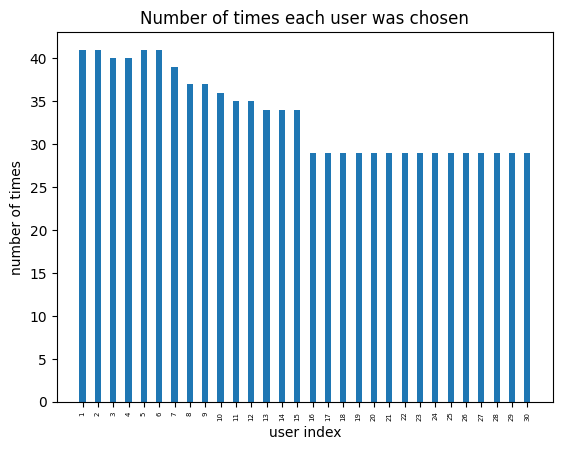

In [20]:


choices_table = np.zeros((args.global_epochs, args.num_users))
num_of_obs_arr = np.zeros((1,args.num_users))
train_loss_list = []
val_acc_list = []
val_losses_list = []
l1_norm_avg_deltha_theta_list = []
global_epochs_time_list = []


time_counter = 0
for global_epoch in tqdm(range(1, args.global_epochs+1)):
    """Part 1: Choosing Users"""
    for usr_idx in range(args.num_users):
        local_models[usr_idx].update_g(global_epoch)
        local_models[usr_idx].update_ucb(global_epoch)
    
    if args.choosing_users_verbose:
        print(f"iteration: {global_epoch}")
    a=time.time()
    rounds_choise = utils.choose_users(local_models, args, global_epoch, method=args.method_choosing_users)

    
    #choices_table[global_epoch-1, rounds_choise] = 1
    num_of_obs_arr[0,rounds_choise] += 1
    for usr_idx in rounds_choise:
        local_models[usr_idx].update_emp_avg()
        local_models[usr_idx].update_privacy_violation_and_reward()
        local_models[usr_idx].increase_num_of_obs()
        if args.choosing_users_verbose:
            print(f"user {usr_idx}, g: {local_models[usr_idx].g}, ucb: {local_models[usr_idx].ucb}, num_of_obs: {local_models[usr_idx].num_of_obs}, privacy reward: {local_models[usr_idx].privacy_reward}, curr_delay = {local_models[usr_idx].last_access_time}")
    
    max_delay = max([local_models[i].last_access_time for i in rounds_choise])
    if args.choosing_users_verbose:
        print(f"max_delay = {max_delay:.2f} seconds")
    
    
    """Part 2: Training"""
#     learning_utils.distribute_model(local_models, global_model)
#     users_avg_loss_over_local_epochs = []

#     for user_idx in rounds_choise:
#         user_loss = []
#         for local_epoch in range(args.local_epochs):
#             user = local_models[user_idx]
#             train_loss = learning_utils.train_one_epoch(user, train_criterion, args)
#             if args.lr_scheduler:
#                 user.scheduler.step(train_loss)
#             user_loss.append(train_loss)
#         users_avg_loss_over_local_epochs.append(mean(user_loss))
    
#     avg_loss_over_chosen_users_curr_global_epoch = mean(users_avg_loss_over_local_epochs)
#     train_loss_list.append(avg_loss_over_chosen_users_curr_global_epoch)


#     avg_deltha_theta = learning_utils.Fed_avg_models(local_models, global_model, rounds_choise,
#                                                       args, snr_verbose = args.snr_verbose)
#     # l1_norm_avg_deltha_theta = sum(LA.vector_norm(param.flatten(),1) for param in avg_deltha_theta.values())
#     # l1_norm_avg_deltha_theta_list.append(l1_norm_avg_deltha_theta)
#     # print(f"l1_norm_avg_deltha_theta is {l1_norm_avg_deltha_theta}")
    

#     val_acc, val_loss = learning_utils.test(test_loader, global_model, test_criterion, args)
#     val_acc_list.append(val_acc) ; val_losses_list.append(val_loss)
    

#     # boardio.add_scalars("Losses over time in seconds", {"train_loss":avg_loss_over_chosen_users_curr_global_epoch,
#     #                                     "val_loss": val_loss}, time.time()-start_time)
#     # boardio.add_scalar('Val Accuracy', val_acc, time.time()-start_time)


#     time_counter += max_delay
#     print((f"global epoch {global_epoch} has been done artifficialy in {max_delay:.2f} secs, the total time by now is {time_counter:.2f} \n with avg train loss {avg_loss_over_chosen_users_curr_global_epoch:.3f}, val loss {val_loss:.3f}, avg val acc {val_acc:.2f}%"))
#     global_epochs_time_list.append(time_counter)
#     gc.collect()


#     if val_acc > best_val_acc and args.save_best_model:
#         best_val_acc = val_acc
#         torch.save({"model's state dict":global_model.state_dict(),
#                     "train_loss_list": train_loss_list,
#                     "val_acc_list": val_acc_list,
#                     "val_losses_list": val_losses_list,
#                     "global_epochs_time_list": global_epochs_time_list,
#                     "num_of_users": args.num_users,
#                     "num_of_users_per_round": args.num_users_per_round,
#                     "l1_norm_avg_deltha_theta_list": l1_norm_avg_deltha_theta_list}
#                     , path_best_model)
    
    
#     torch.save({"model's state dict":global_model.state_dict(),
#                 "train_loss_list": train_loss_list,
#                 "val_acc_list": val_acc_list,
#                 "val_losses_list": val_losses_list,
#                 "global_epochs_time_list": global_epochs_time_list,
#                 "num_of_obs_arr": num_of_obs_arr.reshape(-1),
#                 "global_epoch": global_epoch,
#                 "num_of_users": args.num_users,
#                 "num_of_users_per_round": args.num_users_per_round,
#                 "l1_norm_avg_deltha_theta_list": l1_norm_avg_deltha_theta_list}
#                 , last_model_path)

#     if time_counter > args.max_seconds:
#         break

users_idxs = tuple([str(x) for x in range(1,args.num_users+1)])
plt.bar(users_idxs, num_of_obs_arr.reshape(-1), width = 0.4)
plt.title("Number of times each user was chosen")
plt.ylabel("number of times")
plt.xlabel("user index")
plt.xticks(rotation=90, fontsize=5)
#boardio.add_figure("Number of times each user was chosen", fig, global_epoch)
plt.savefig(last_model_path.parent / "Number of times each user was chosen.png")

#choices_table = choices_table.cumsum(axis=0)
